In [1]:
import pandas as pd
import numpy as np
import math as math
import statistics
import time
import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 1000)  
pd.set_option('display.width', 150)
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

# Glossary.csv SOURCED FROM:
https://www.nba.com/stats/help/glossary

In [2]:
glossaryDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Glossary.csv')
glossaryDict = {}
for i in range(len(glossaryDF)):
    stringInRow = glossaryDF.iloc[i].values[0]
    if stringInRow == 'Name':
        feature = glossaryDF.iloc[i-1].values[0]
        feature = feature.upper()
        glossaryDict[feature] = {}
        glossaryDict[feature]['Name'] = {}
        glossaryDict[feature]['Name'] = glossaryDF.iloc[i+1].values[0]
        glossaryDict[feature]['Definition'] = {}
        glossaryDict[feature]['Definition'] = glossaryDF.iloc[i+3].values[0]
        glossaryDict[feature]['Type'] = {}
        glossaryDict[feature]['Type'] = glossaryDF.iloc[i+5].values[0]
        glossaryDict[feature]['Contexts'] = {}
        
#FEATURES NOT IN https://www.nba.com/stats/help/glossary
glossaryDict['H/A'] = {}
glossaryDict['H/A']['Name'] = 'Home or Away'
glossaryDict['H/A']['Definition'] = '0:HOME 1:AWAY'

glossaryDict['PTSA'] = {}
glossaryDict['PTSA']['Name'] = 'Points Allowed'
glossaryDict['PTSA']['Definition'] = 'The number of points allowed'

glossaryDict['PTSDELTA'] = {}
glossaryDict['PTSDELTA']['Name'] = 'Points Scored - Points Allowed'
glossaryDict['PTSDELTA']['Definition'] = 'Points Scored - Points Allowed'

glossaryDict['DAYSOFF'] = {}
glossaryDict['DAYSOFF']['Name'] = 'Number of days since last game'
glossaryDict['DAYSOFF']['Definition'] = 'Number of days since last game'

glossaryDict['W%'] = {}
glossaryDict['W%']['Name'] = 'The percentage of games played that a player or team has won'
glossaryDict['W%']['Definition'] = 'The percentage of games played that a player or team has won'

glossaryDict['L%'] = {}
glossaryDict['L%']['Name'] = 'The percentage of games played that a player or team has lost'
glossaryDict['L%']['Definition'] = 'The percentage of games played that a player or team has lost'

In [3]:
def convertDateColumn(df):
    locationToInsert = df.columns.get_loc('DATE')+1
    dates = pd.to_datetime(df['DATE'],format="%m/%d/%y").dt.date
    df = df.drop(columns='DATE')
    df.insert(locationToInsert,'DATE',dates)
    df = df.sort_values(by=['DATE','GAMEID']).reset_index(drop=True)
    return df
def featureEngineering(boxScoreType,df):
    if boxScoreType == 'TRADITIONAL':
        featuresToAddDict = {'OPPT':[],'PTSA':[],'2FGA':[],'2FGM':[],'2FG%':[],
                             'RESULT':[],'PTSDELTA':[],'H/A':[]}
        for i in range(len(df)):
            featuresToAddDict['OPPT'].append(df.iloc[i]['MATCH'][-3:])
            if i % 2 == 0: featuresToAddDict['PTSA'].append(df.iloc[i+1]['PTS'])
            else: featuresToAddDict['PTSA'].append(df.iloc[i-1]['PTS'])
            if df['W/L'][i] == 'L': featuresToAddDict['RESULT'].append(0)
            else: featuresToAddDict['RESULT'].append(1)
            featuresToAddDict['H/A'].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict['OPPT'])
        df.insert(df.columns.get_loc('PTS')+1,'PTSA',featuresToAddDict['PTSA'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGM',df['FGM'] - df['3PM'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGA',df['FGA'] - df['3PA']) 
        df.insert(df.columns.get_loc('FG%')+1,'2FG%',df['2FGM']/df['2FGA'])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict['RESULT'])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('PTSA')+1,'PTSDELTA',df['PTS']-df['PTSA'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict['H/A'])
        return df
    else:
        featuresToAddDict = {"OPPT":[],"RESULT":[],"H/A":[]}
        for i in range(len(df)):
            featuresToAddDict["OPPT"].append(df.iloc[i]['MATCH'][-3:])
            if df['W/L'][i] == 'L': featuresToAddDict["RESULT"].append(0)
            else: featuresToAddDict["RESULT"].append(1)
            featuresToAddDict["H/A"].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict["OPPT"])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict["RESULT"])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict["H/A"])
        return df
def addDaysOff(teamsDict):
    for team in list(teamsDict.keys()):
        daysOff = []
        daysOff.append(np.nan)
        for i in range(1,len(teamsDict[team]['DATE'])):
            date = teamsDict[team]['DATE'][i]
            prevDate = teamsDict[team]['DATE'][i-1] + datetime.timedelta(1)
            daysOff.append((date - prevDate).days)
        teamsDict[team]['DAYSOFF'] = daysOff
def addAdditionalFeatures(df,teamsDict):
    teams = []
    for team in list(teamsDict.keys()):
        teamDF = df[df['TEAM'] == team]
        startingIndex = len(list(df.columns))
        additionalFeatures = list(teamsDict[team].keys())[startingIndex:]
        for feature in additionalFeatures:
            teamDF = pd.concat([teamDF,
                                pd.DataFrame(teamsDict[team][feature],columns=[feature],index=teamDF.index.values)],axis=1)
        teams.append(teamDF)
    return pd.concat(teams)

def getTeamData(boxScoreType,df):
    teamsDict = {}
    features = df.columns.values
    
    if boxScoreType == 'TRADITIONAL': additionalFeatures = ['Ws','Ls','GP','W%','L%','AVGPTS','AVGPTSA']
  
    else: additionalFeatures = ['GP']
    for team in np.unique(df['TEAM']):
        teamsDict[team] = {}
    for team in np.unique(df['TEAM']):
        for feature in features:
            teamsDict[team][feature] = []
        for feature in additionalFeatures:
            teamsDict[team][feature] = []
    for i in range(len(df)):
        for feature in features:
            team = df.iloc[i]['TEAM']
            teamsDict[team][feature].append(df.iloc[i][feature])
        for feature in additionalFeatures:
            if feature == 'Ws': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(1))
            if feature == 'Ls': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(0))
            if feature == 'GP': teamsDict[team][feature].append(len(teamsDict[team]['RESULT']))
            if feature == 'W%': teamsDict[team][feature].append(teamsDict[team]['Ws'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'L%': teamsDict[team][feature].append(teamsDict[team]['Ls'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'AVGPTS': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTS']))
            if feature == 'AVGPTSA': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTSA']))
    return teamsDict

def addMovingAverageLx(featureStringsDict,teamDict,x):
    for team in list(teamsDict.keys()):
        for feature in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][feature])-x):
                ma.append(np.mean(teamsDict[team][feature][maRange:(x+maRange)]))
            teamsDict[team][featureStringsDict[feature].replace('x',str(x))] = ma
                
def addPercentMovingAverageLx(featureStringsDict,teamsDict,x):
    for team in list(teamsDict.keys()):
        for features in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][features[0]])-x):
                num = np.sum(teamsDict[team][features[0]][maRange:(x+maRange)])
                dem = np.sum(teamsDict[team][features[1]][maRange:(x+maRange)])
                ma.append(num/dem)
            teamsDict[team][featureStringsDict[features].replace('x',str(x))] = ma

# Traditional.csv

In [4]:
traditionalDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Traditional.csv')
traditionalDF = convertDateColumn(traditionalDF)
traditionalDF = featureEngineering('TRADITIONAL',traditionalDF)
teamsDict = getTeamData('TRADITIONAL',traditionalDF)

In [5]:
features = ['PTS','PTSA','PTSDELTA','FGM','FGA','2FGA','2FGM','3PM','3PA','FTM','FTA','OREB',
            'DREB','REB','AST','STL','BLK','TOV','PF']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA'
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)
features = [('FGM','FGA'),('2FGM','2FGA'),('3PM','3PA'),('FTM','FTA'),('Ws','GP')]
featureStringsDict = {}
for feature in features:
    if feature == ('FGM','FGA'): featureStringsDict[feature] = 'FG%LxMA'
    if feature == ('2FGM','2FGA'): featureStringsDict[feature] = '2FG%LxMA'
    if feature == ('3PM','3PA'): featureStringsDict[feature] = '3P%LxMA'
    if feature == ('FTM','FTA'): featureStringsDict[feature] = 'FT%LxMA'
addPercentMovingAverageLx(featureStringsDict,teamsDict,5)
addPercentMovingAverageLx(featureStringsDict,teamsDict,4)
addPercentMovingAverageLx(featureStringsDict,teamsDict,3)
addPercentMovingAverageLx(featureStringsDict,teamsDict,2)
addPercentMovingAverageLx(featureStringsDict,teamsDict,1)
addDaysOff(teamsDict)
traditionalDF = addAdditionalFeatures(traditionalDF,teamsDict)
traditionalDF = traditionalDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

<ipython-input-3-cc31cfbcd612>:107: RuntimeWarning: invalid value encountered in scalar divide
  ma.append(num/dem)


In [6]:
print('In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks')
print('Causing a warning while calculating Celtics FT%L1MA')
print('Excluded BOS FT%L1MA feature from train')
traditionalDF[traditionalDF['FTA'] == 0]

In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks
Causing a warning while calculating Celtics FT%L1MA
Excluded BOS FT%L1MA feature from train


TEAM OPPT      TEAMID      MATCH    GAMEID  RESULT        DATE  H/A  SPREAD    O/U  MIN  PTS  PTSA  PTSDELTA  FGM  FGA   FG%      2FG%  2FGA  \
2354  BOS  MIL  1610612738  BOS @ MIL  22301148       0  2024-04-09    0     3.5  231.0  240   91   104       -13   37   93  39.8  0.487805    41   

      2FGM  3PM  3PA   3P%  FTM  FTA  FT%  OREB  DREB  REB  AST  STL  BLK  TOV  PF  +/-  Ws  Ls  GP       W%       L%      AVGPTS     AVGPTSA  \
2354    20   17   52  32.7    0    0  0.0    12    26   38   27   11    4   12   8  -13  62  17  79  0.78481  0.21519  120.443038  109.101266   

      PTSL5MA  PTSAL5MA  PTSDELTAL5MA  FGML5MA  FGAL5MA  2FGAL5MA  2FGML5MA  3PML5MA  3PAL5MA  FTML5MA  FTAL5MA  OREBL5MA  DREBL5MA  REBL5MA  \
2354    116.4     100.6          15.8     43.8     87.8      45.4      28.0     15.8     42.4     13.0     15.6       9.4      38.4     47.8   

      ASTL5MA  STLL5MA  BLKL5MA  TOVL5MA  PFL5MA  PTSL4MA  PTSAL4MA  PTSDELTAL4MA  FGML4MA  FGAL4MA  2FGAL4MA  2FGML4MA  3PML4MA  3PAL4MA  FTML4MA  \
2354     29.4      6.8      6.4     11.2    13.8    119.5    102.75         16.75     45.0    89.25      45.5      29.0     16.0    43.75     13.5   

      FTAL4MA  OREBL4MA  DREBL4MA  REBL4MA  ASTL4MA  STLL4MA  BLKL4MA  TOVL4MA  PFL4MA  PTSL3MA    PTSAL3MA  PTSDELTAL3MA    FGML3MA    FGAL3MA  \
2354     16.5      9.75     37.25     47.0     30.0     6.75     6.25    10.75    14.0    120.0  102.333333     17.666667  45.666667  89.333333   

       2FGAL3MA   2FGML3MA  3PML3MA    3PAL3MA    FTML3MA    FTAL3MA  OREBL3MA   DREBL3MA    REBL3MA    ASTL3MA  STLL3MA   BLKL3MA    TOVL3MA  \
2354  48.666667  30.666667     15.0  40.666667  13.666667  16.666667  9.333333  36.333333  45.666667  30.666667      8.0  7.333333  10.666667   

         PFL3MA  PTSL2MA  PTSAL2MA  PTSDELTAL2MA  FGML2MA  FGAL2MA  2FGAL2MA  2FGML2MA  3PML2MA  3PAL2MA  FTML2MA  FTAL2MA  OREBL2MA  DREBL2MA  \
2354  13.666667    112.5     103.5           9.0     43.5     88.0      47.0      29.5     14.0     41.0     11.5     15.5       8.5      37.0   

      REBL2MA  ASTL2MA  STLL2MA  BLKL2MA  TOVL2MA  PFL2MA  PTSL1MA  PTSAL1MA  PTSDELTAL1MA  FGML1MA  FGAL1MA  2FGAL1MA  2FGML1MA  3PML1MA  3PAL1MA  \
2354     45.5     29.5      8.5      6.0     10.5    11.5    124.0     107.0          17.0     49.0     87.0      49.0      33.0     16.0     38.0   

      FTML1MA  FTAL1MA  OREBL1MA  DREBL1MA  REBL1MA  ASTL1MA  STLL1MA  BLKL1MA  TOVL1MA  PFL1MA   FG%L5MA  2FG%L5MA   3P%L5MA   FT%L5MA   FG%L4MA  \
2354     10.0     13.0       5.0      35.0     40.0     34.0     11.0      8.0     13.0    12.0  0.498861   0.61674  0.372642  0.833333  0.504202   

      2FG%L4MA   3P%L4MA   FT%L4MA   FG%L3MA  2FG%L3MA   3P%L3MA  FT%L3MA   FG%L2MA  2FG%L2MA   3P%L2MA   FT%L2MA   FG%L1MA  2FG%L1MA   3P%L1MA  \
2354  0.637363  0.365714  0.818182  0.511194  0.630137  0.368852     0.82  0.494318   0.62766  0.341463  0.741935  0.563218  0.673469  0.421053   

       FT%L1MA  DAYSOFF  
2354  0.769231      1.0

In [7]:
traditionalFeatures = list(traditionalDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'SPREAD','O/U','MIN','PTS','PTSA','PTSDELTA','FGM','FGA','FG%',
                            '2FG%','2FGA','2FGM','3PM','3PA','3P%','FTM','FTA','FT%','OREB',
                            'DREB','REB','AST','STL','BLK','TOV','PF','+/-','Ws','Ls', 'GP',
                            'W%', 'L%', 'AVGPTS','AVGPTSA'])
for feature in columnsToRemove: traditionalFeatures.remove(feature)
print(traditionalFeatures)

['H/A', 'PTSL5MA', 'PTSAL5MA', 'PTSDELTAL5MA', 'FGML5MA', 'FGAL5MA', '2FGAL5MA', '2FGML5MA', '3PML5MA', '3PAL5MA', 'FTML5MA', 'FTAL5MA', 'OREBL5MA', 'DREBL5MA', 'REBL5MA', 'ASTL5MA', 'STLL5MA', 'BLKL5MA', 'TOVL5MA', 'PFL5MA', 'PTSL4MA', 'PTSAL4MA', 'PTSDELTAL4MA', 'FGML4MA', 'FGAL4MA', '2FGAL4MA', '2FGML4MA', '3PML4MA', '3PAL4MA', 'FTML4MA', 'FTAL4MA', 'OREBL4MA', 'DREBL4MA', 'REBL4MA', 'ASTL4MA', 'STLL4MA', 'BLKL4MA', 'TOVL4MA', 'PFL4MA', 'PTSL3MA', 'PTSAL3MA', 'PTSDELTAL3MA', 'FGML3MA', 'FGAL3MA', '2FGAL3MA', '2FGML3MA', '3PML3MA', '3PAL3MA', 'FTML3MA', 'FTAL3MA', 'OREBL3MA', 'DREBL3MA', 'REBL3MA', 'ASTL3MA', 'STLL3MA', 'BLKL3MA', 'TOVL3MA', 'PFL3MA', 'PTSL2MA', 'PTSAL2MA', 'PTSDELTAL2MA', 'FGML2MA', 'FGAL2MA', '2FGAL2MA', '2FGML2MA', '3PML2MA', '3PAL2MA', 'FTML2MA', 'FTAL2MA', 'OREBL2MA', 'DREBL2MA', 'REBL2MA', 'ASTL2MA', 'STLL2MA', 'BLKL2MA', 'TOVL2MA', 'PFL2MA', 'PTSL1MA', 'PTSAL1MA', 'PTSDELTAL1MA', 'FGML1MA', 'FGAL1MA', '2FGAL1MA', '2FGML1MA', '3PML1MA', '3PAL1MA', 'FTML1MA', 'F

# Advanced.csv

In [8]:
advancedDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Advanced.csv')
advancedDF = convertDateColumn(advancedDF)
advancedDF = featureEngineering('ADVANCED',advancedDF)
teamsDict = getTeamData('ADVANCED',advancedDF)

In [9]:
features = ['OFFRTG','DEFRTG','NETRTG','AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
            'EFG%','TS%','PACE','PIE']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)
advancedDF = addAdditionalFeatures(advancedDF,teamsDict)
advancedDF = advancedDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [10]:
advancedFeatures = list(advancedDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'H/A','SPREAD','O/U','MIN','OFFRTG','DEFRTG','NETRTG',
                            'AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
                            'EFG%','TS%','PACE','PIE','GP'])
for feature in columnsToRemove: advancedFeatures.remove(feature)
print(advancedFeatures)

['OFFRTGL5MA', 'DEFRTGL5MA', 'NETRTGL5MA', 'AST%L5MA', 'AST/TOL5MA', 'AST RATIOL5MA', 'OREB%L5MA', 'DREB%L5MA', 'REB%L5MA', 'TOV%L5MA', 'EFG%L5MA', 'TS%L5MA', 'PACEL5MA', 'PIEL5MA', 'OFFRTGL4MA', 'DEFRTGL4MA', 'NETRTGL4MA', 'AST%L4MA', 'AST/TOL4MA', 'AST RATIOL4MA', 'OREB%L4MA', 'DREB%L4MA', 'REB%L4MA', 'TOV%L4MA', 'EFG%L4MA', 'TS%L4MA', 'PACEL4MA', 'PIEL4MA', 'OFFRTGL3MA', 'DEFRTGL3MA', 'NETRTGL3MA', 'AST%L3MA', 'AST/TOL3MA', 'AST RATIOL3MA', 'OREB%L3MA', 'DREB%L3MA', 'REB%L3MA', 'TOV%L3MA', 'EFG%L3MA', 'TS%L3MA', 'PACEL3MA', 'PIEL3MA', 'OFFRTGL2MA', 'DEFRTGL2MA', 'NETRTGL2MA', 'AST%L2MA', 'AST/TOL2MA', 'AST RATIOL2MA', 'OREB%L2MA', 'DREB%L2MA', 'REB%L2MA', 'TOV%L2MA', 'EFG%L2MA', 'TS%L2MA', 'PACEL2MA', 'PIEL2MA', 'OFFRTGL1MA', 'DEFRTGL1MA', 'NETRTGL1MA', 'AST%L1MA', 'AST/TOL1MA', 'AST RATIOL1MA', 'OREB%L1MA', 'DREB%L1MA', 'REB%L1MA', 'TOV%L1MA', 'EFG%L1MA', 'TS%L1MA', 'PACEL1MA', 'PIEL1MA']


# FourFactors.csv

In [11]:
fourFactorsDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/FourFactors.csv')
fourFactorsDF = convertDateColumn(fourFactorsDF)
fourFactorsDF = featureEngineering('FOURFACTORS',fourFactorsDF)
teamsDict = getTeamData('FOURFACTORS',fourFactorsDF)

In [12]:
features = ['EFG%','FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE','OPP TOV%','OPP OREB%']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)
fourFactorsDF = addAdditionalFeatures(fourFactorsDF,teamsDict)
fourFactorsDF = fourFactorsDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [13]:
fourFactorsFeatures = list(fourFactorsDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A',
                            'SPREAD','O/U','MIN','EFG%','FTA RATE','TOV%','OREB%','OPP EFG%',
                            'OPP FTA RATE','OPP TOV%','OPP OREB%','GP'])
for feature in columnsToRemove: fourFactorsFeatures.remove(feature)
print(fourFactorsFeatures)

['EFG%L5MA', 'FTA RATEL5MA', 'TOV%L5MA', 'OREB%L5MA', 'OPP EFG%L5MA', 'OPP FTA RATEL5MA', 'OPP TOV%L5MA', 'OPP OREB%L5MA', 'EFG%L4MA', 'FTA RATEL4MA', 'TOV%L4MA', 'OREB%L4MA', 'OPP EFG%L4MA', 'OPP FTA RATEL4MA', 'OPP TOV%L4MA', 'OPP OREB%L4MA', 'EFG%L3MA', 'FTA RATEL3MA', 'TOV%L3MA', 'OREB%L3MA', 'OPP EFG%L3MA', 'OPP FTA RATEL3MA', 'OPP TOV%L3MA', 'OPP OREB%L3MA', 'EFG%L2MA', 'FTA RATEL2MA', 'TOV%L2MA', 'OREB%L2MA', 'OPP EFG%L2MA', 'OPP FTA RATEL2MA', 'OPP TOV%L2MA', 'OPP OREB%L2MA', 'EFG%L1MA', 'FTA RATEL1MA', 'TOV%L1MA', 'OREB%L1MA', 'OPP EFG%L1MA', 'OPP FTA RATEL1MA', 'OPP TOV%L1MA', 'OPP OREB%L1MA']


# Misc.csv

In [14]:
miscDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Misc.csv')
miscDF = convertDateColumn(miscDF)
miscDF = featureEngineering('MISC',miscDF)
teamsDict = getTeamData('MISC',miscDF)

In [15]:
features = ['PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO','OPP 2ND PTS','OPP FBPS','OPP PITP']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

miscDF = addAdditionalFeatures(miscDF,teamsDict)
miscDF = miscDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [16]:
miscFeatures = list(miscDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO',
                            'OPP 2ND PTS','OPP FBPS','OPP PITP','GP'])
for feature in columnsToRemove: miscFeatures.remove(feature)
print(miscFeatures)

['PTS OFF TOL5MA', '2ND PTSL5MA', 'FBPSL5MA', 'PITPL5MA', 'OPP PTS OFF TOL5MA', 'OPP 2ND PTSL5MA', 'OPP FBPSL5MA', 'OPP PITPL5MA', 'PTS OFF TOL4MA', '2ND PTSL4MA', 'FBPSL4MA', 'PITPL4MA', 'OPP PTS OFF TOL4MA', 'OPP 2ND PTSL4MA', 'OPP FBPSL4MA', 'OPP PITPL4MA', 'PTS OFF TOL3MA', '2ND PTSL3MA', 'FBPSL3MA', 'PITPL3MA', 'OPP PTS OFF TOL3MA', 'OPP 2ND PTSL3MA', 'OPP FBPSL3MA', 'OPP PITPL3MA', 'PTS OFF TOL2MA', '2ND PTSL2MA', 'FBPSL2MA', 'PITPL2MA', 'OPP PTS OFF TOL2MA', 'OPP 2ND PTSL2MA', 'OPP FBPSL2MA', 'OPP PITPL2MA', 'PTS OFF TOL1MA', '2ND PTSL1MA', 'FBPSL1MA', 'PITPL1MA', 'OPP PTS OFF TOL1MA', 'OPP 2ND PTSL1MA', 'OPP FBPSL1MA', 'OPP PITPL1MA']


# Scoring.csv

In [17]:
scoringDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Scoring.csv')
scoringDF = convertDateColumn(scoringDF)
scoringDF = featureEngineering('SCORING',scoringDF)
teamsDict = getTeamData('SCORING',scoringDF)

In [18]:
features = ['%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT','%PTS FBPS','%PTS FT',
            '%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST','3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

scoringDF = addAdditionalFeatures(scoringDF,teamsDict)
scoringDF = scoringDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [19]:
scoringFeatures = list(scoringDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT',
                            '%PTS FBPS','%PTS FT','%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST',
                            '3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST','GP'])
for feature in columnsToRemove: scoringFeatures.remove(feature)
print(scoringFeatures)

['%FGA 2PTL5MA', '%FGA 3PTL5MA', '%PTS 2PTL5MA', '%PTS 2PT MRL5MA', '%PTS 3PTL5MA', '%PTS FBPSL5MA', '%PTS FTL5MA', '%PTS OFF TOL5MA', '%PTS PITPL5MA', '2FGM %ASTL5MA', '2FGM %UASTL5MA', '3FGM %ASTL5MA', '3FGM %UASTL5MA', 'FGM %ASTL5MA', 'FGM %UASTL5MA', '%FGA 2PTL4MA', '%FGA 3PTL4MA', '%PTS 2PTL4MA', '%PTS 2PT MRL4MA', '%PTS 3PTL4MA', '%PTS FBPSL4MA', '%PTS FTL4MA', '%PTS OFF TOL4MA', '%PTS PITPL4MA', '2FGM %ASTL4MA', '2FGM %UASTL4MA', '3FGM %ASTL4MA', '3FGM %UASTL4MA', 'FGM %ASTL4MA', 'FGM %UASTL4MA', '%FGA 2PTL3MA', '%FGA 3PTL3MA', '%PTS 2PTL3MA', '%PTS 2PT MRL3MA', '%PTS 3PTL3MA', '%PTS FBPSL3MA', '%PTS FTL3MA', '%PTS OFF TOL3MA', '%PTS PITPL3MA', '2FGM %ASTL3MA', '2FGM %UASTL3MA', '3FGM %ASTL3MA', '3FGM %UASTL3MA', 'FGM %ASTL3MA', 'FGM %UASTL3MA', '%FGA 2PTL2MA', '%FGA 3PTL2MA', '%PTS 2PTL2MA', '%PTS 2PT MRL2MA', '%PTS 3PTL2MA', '%PTS FBPSL2MA', '%PTS FTL2MA', '%PTS OFF TOL2MA', '%PTS PITPL2MA', '2FGM %ASTL2MA', '2FGM %UASTL2MA', '3FGM %ASTL2MA', '3FGM %UASTL2MA', 'FGM %ASTL2MA', 

# 327 APPLICABLE FEATURE

In [20]:
applicableFeatures = traditionalFeatures + advancedFeatures + fourFactorsFeatures + miscFeatures + scoringFeatures
applicableFeatures = np.unique(applicableFeatures,return_counts=True)[0]
print(len(applicableFeatures))

327


In [21]:
NBAdf = pd.concat([traditionalDF,
                   advancedDF.drop(columns=['TEAM']),
                   fourFactorsDF.drop(columns=['TEAM']),
                   miscDF.drop(columns=['TEAM']),
                   scoringDF.drop(columns=['TEAM'])],axis=1)
NBAdf = NBAdf.dropna()

In [22]:
teamCorrelationResults = {}
for team in NBATeams:
    teamCorrelationResults[team] = {}
    for feature in applicableFeatures:
        teamCorrelationResults[team][feature] = {}
        teamCorrelationResults[team][feature]['TEAM'] = team
        teamCorrelationResults[team][feature]['FEATURE'] = feature
        teamCorrelationResults[team][feature]['R'] = float
        teamCorrelationResults[team][feature]['P'] = float

In [23]:
for team in NBATeams:
    teamDF = NBAdf[NBAdf['TEAM'] == team].reset_index(drop=True)
    for feature in applicableFeatures:
        df = pd.concat([pd.DataFrame(teamDF[feature]),
                            pd.DataFrame(teamDF['PTS'])],axis=1)
        if len(df.columns) > 1: #checking for repeated columns
            df = pd.concat([pd.DataFrame(df.iloc[:,0]),
                            pd.DataFrame(df['PTS'])],axis=1)
        R,P = pearsonr(df[feature],df['PTS'])
        teamCorrelationResults[team][feature]['R'] = R
        teamCorrelationResults[team][feature]['P'] = P

In [24]:
leagueCorrelationResultsDF = pd.DataFrame()
for team in NBATeams:
    teamDF = pd.DataFrame(teamCorrelationResults[team]).T
    teamDF = teamDF.reset_index(drop=True).sort_values(by='R',ascending=False)
    leagueCorrelationResultsDF = pd.concat([leagueCorrelationResultsDF,teamDF],axis=0)
leagueCorrelationResultsDF = leagueCorrelationResultsDF.reset_index(drop=True)
leagueCorrelationResultsDF = leagueCorrelationResultsDF.sort_values(by='R',ascending=False)
leagueCorrelationResultsDF

TEAM      FEATURE         R         P
0     ATL   DEFRTGL2MA  0.505035  0.000003
1     ATL   DEFRTGL4MA  0.461526  0.000024
2     ATL     PTSAL2MA  0.461484  0.000024
3     ATL   DEFRTGL3MA  0.460478  0.000025
9156  UTA      PIEL5MA  0.458305  0.000028
...   ...          ...       ...       ...
6862  OKC    OREB%L5MA -0.390265   0.00045
6863  OKC    OREB%L2MA -0.403079  0.000278
6864  OKC    OREB%L3MA -0.405836   0.00025
6865  OKC    OREB%L4MA -0.417576  0.000158
6866  OKC  2ND PTSL2MA -0.461341  0.000024

[9810 rows x 4 columns]

In [25]:
def getFeatureDefintion(feature):
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    return(glossaryDict[feature]['Definition'])
def getCorrelationCoefficient(x,y):
    num = len(x)*np.sum(x*y) - (sum(x)*sum(y))
    den = np.sqrt((len(x)*np.sum(x**2)-(np.sum(x)**2)) * (len(x)*np.sum(y**2)-(np.sum(y)**2)))
    r = num/den
    return r
def regressionEquation(x,y):
    num = (len(x)*np.sum(x*y)) - (sum(x)*sum(y))
    den = (len(x)*np.sum(x**2))-(np.sum(x)**2)
    slope = num/den
    y_intercept = (np.sum(y) - slope*np.sum(x)) / len(x)
    return 'y = '+str(round(slope,4))+'x + '+str(round(y_intercept,4))
# import copy
def getFeatureDefintionWrapped(feature):
    orginalFeature = feature
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definition = orginalFeature+': '+glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return textwrap.fill(definition,35)
def getFeatureDefintion(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definition = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return definition
def getFeatureName(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    name = glossaryDict[feature]['Name']
    return name

In [67]:
def plotTeamMaxMinFeatureToPointsCorrelation(team,NBAdf,leagueCorrelationResultsDF):
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
    ax0,ax1 = axes.flatten()
    maxFeature = leagueCorrelationResultsDF[leagueCorrelationResultsDF['TEAM'] == team].head(1)['FEATURE'].values[0]
    R = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == maxFeature)]['R'].values[0]
    p = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == maxFeature)]['P'].values[0]
    R2 = R**2
    teamDF = NBAdf[NBAdf['TEAM'] == team]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = pd.concat([pd.DataFrame(teamDF[maxFeature]),
                        pd.DataFrame(teamDF['PTS'])],axis=1)
    if len(teamDF.columns) > 1: #The column label 'TOV%L2MA' is not unique.
        teamDF = pd.concat([pd.DataFrame(teamDF.iloc[:,0]),
                        pd.DataFrame(teamDF['PTS'])],axis=1)
    teamDF = teamDF.reset_index(drop=True)
    teamDF = teamDF.sort_values(by=maxFeature)
    polyfit = np.polyfit(teamDF[maxFeature],teamDF['PTS'],1)
    polynomial = np.poly1d(polyfit)
    
    bestFitLine = regressionEquation(teamDF[maxFeature],teamDF['PTS'])
    label = bestFitLine
    defintion = getFeatureDefintionWrapped(maxFeature)
    ax0.set_xlabel(maxFeature,size=20,fontweight='bold');
    ax0.set_ylabel(team+' POINTS SCORED',size=30,fontweight='bold');
    ax0.set_xlabel('\n'+defintion,loc='left',size=25)

    ax0.set_title('R:'+f'{R:.6f}'+' R2:'+f'{R2:.6f}'+' p:'+f'{p:.6f}',size=25,fontweight ='bold');
    ax0.tick_params(labelsize=25)
    ax0.scatter(teamDF[maxFeature],teamDF['PTS'],marker='o',s=75);
    ax0.plot(teamDF[maxFeature].values,polynomial(teamDF[maxFeature].values),linestyle='--',linewidth=3,label=label)
    ax0.grid(True,linewidth=.5)
    ax0.legend(loc="upper left",prop={'size':25})
    
    
    minFeature = leagueCorrelationResultsDF[leagueCorrelationResultsDF['TEAM'] == team].tail(1)['FEATURE'].values[0]
    R = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == minFeature)]['R'].values[0]
    p = leagueCorrelationResultsDF[(leagueCorrelationResultsDF['TEAM'] == team) & 
                                   (leagueCorrelationResultsDF['FEATURE'] == minFeature)]['P'].values[0]
    R2 = R**2
    teamDF = NBAdf[NBAdf['TEAM'] == team]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = pd.concat([pd.DataFrame(teamDF[minFeature]),
                        pd.DataFrame(teamDF['PTS'])],axis=1)
    if len(teamDF.columns) > 1: #The column label 'TOV%L2MA' is not unique.
        teamDF = pd.concat([pd.DataFrame(teamDF.iloc[:,0]),
                        pd.DataFrame(teamDF['PTS'])],axis=1)
    teamDF = teamDF.reset_index(drop=True)
    teamDF = teamDF.sort_values(by=minFeature)
    polyfit = np.polyfit(teamDF[minFeature],teamDF['PTS'],1)
    polynomial = np.poly1d(polyfit)
    
    bestFitLine = regressionEquation(teamDF[minFeature],teamDF['PTS'])
    label = bestFitLine
    defintion = getFeatureDefintionWrapped(minFeature)
    ax1.set_xlabel(minFeature,size=20,fontweight='bold');
    ax1.set_ylabel(team+' POINTS SCORED',size=30,fontweight='bold');
    ax1.set_xlabel('\n'+defintion,loc='left',size=25)

    ax1.set_title('R:'+f'{R:.6f}'+' R2:'+f'{R2:.6f}'+' p:'+f'{p:.6f}',size=25,fontweight ='bold');
    ax1.tick_params(labelsize=25)
    ax1.scatter(teamDF[minFeature],teamDF['PTS'],marker='o',s=75);
    ax1.plot(teamDF[minFeature].values,polynomial(teamDF[minFeature].values),linestyle='--',linewidth=3,label=label)
    ax1.grid(True,linewidth=.5)
    ax1.legend(loc="upper left",prop={'size':25})
    plt.show()
def getTeamMaxFeatureToPointsCorrelation(team):
    maxFeature = leagueCorrelationResultsDF[leagueCorrelationResultsDF['TEAM'] == team].head(1)['FEATURE'].values[0]
    return maxFeature
def getTeamMinFeatureToPointsCorrelation(team):
    minFeature = leagueCorrelationResultsDF[leagueCorrelationResultsDF['TEAM'] == team].tail(1)['FEATURE'].values[0]
    return minFeature

In [96]:
def printTeamResults(team):
    feature = getTeamMaxFeatureToPointsCorrelation(team)
    featureName = getFeatureName(feature)
    print('• For',NBATeamsDict[team],'games played in 2023-24 NBA Regular Season,\n  Feature:',
          featureName,getLastXDetails(feature),
          '\n  has strongest correlation to points scored')
    print()
    feature = getTeamMinFeatureToPointsCorrelation(team)
    featureName = getFeatureName(feature)
    print('• For', NBATeamsDict[team],'games played in 2023-24 NBA Regular Season,\n  Feature:',
          featureName, getLastXDetails(feature),
          '\n  has weakest correlation to points scored')
    
def getLastXDetails(feature):
    values = [1,2,3,4,5]
    notApplicableFeatures = ['H/A','DAYS OFF']
    if feature in notApplicableFeatures: return '('+str(feature)+')'
    else:
        if int((feature[-3])) == 1:
            return 'in last game played feature'+'('+feature+')'
        if int((feature[-3])) == 2:
            return 'in last 2 games played '+'('+feature+')'
        if int((feature[-3])) == 3:
            return 'in last 3 games played '+'('+feature+')'
        if int((feature[-3])) == 4:
            return 'in last 4 games played '+'('+feature+')'
        if int((feature[-3])) == 5:
            return 'in last 5 games played '+'('+feature+')'

NBATeamsDict = {'ATL':'Atlanta Hawks',
                'BKN':'Brooklyn Nets',
                'BOS':'Boston Celtics',
                'CHA':'Charlotte Hornets',
                'CHI':'Chicago Bulls',
                'CLE':'Cleveland Cavaliers',
                'DAL':'Dallas Mavericks',
                'DEN':'Denver Nuggets',
                'DET':'Detroit Pistons',
                'GSW':'Golden State Warriors',
                'HOU':'Houston Rockets',
                'IND':'Indiana Pacers',
                'LAC':'Los Angeles Clippers',
                'LAL':'Los Angeles Lakers',
                'MEM':'Memphis Grizzlies',
                'MIA':'Miami Heat',
                'MIL':'Milwaukee Bucks',
                'MIN':'Minnesota Timberwolves',
                'NOP':'New Orleans Pelicans',
                'NYK':'New York Knicks',
                'OKC':'Oklahoma City Thunder',
                'ORL':'Orlando Magic',
                'PHI':'Philadelphia 76ers',
                'PHX':'Phoenix Suns',
                'POR':'Portland Trail Blazers',
                'SAC':'Sacramento Kings',
                'SAS':'San Antonio Spurs',
                'TOR':'Toronto Raptors',
                'UTA':'Utah Jazz',
                'WAS':'Washington Wizards'}

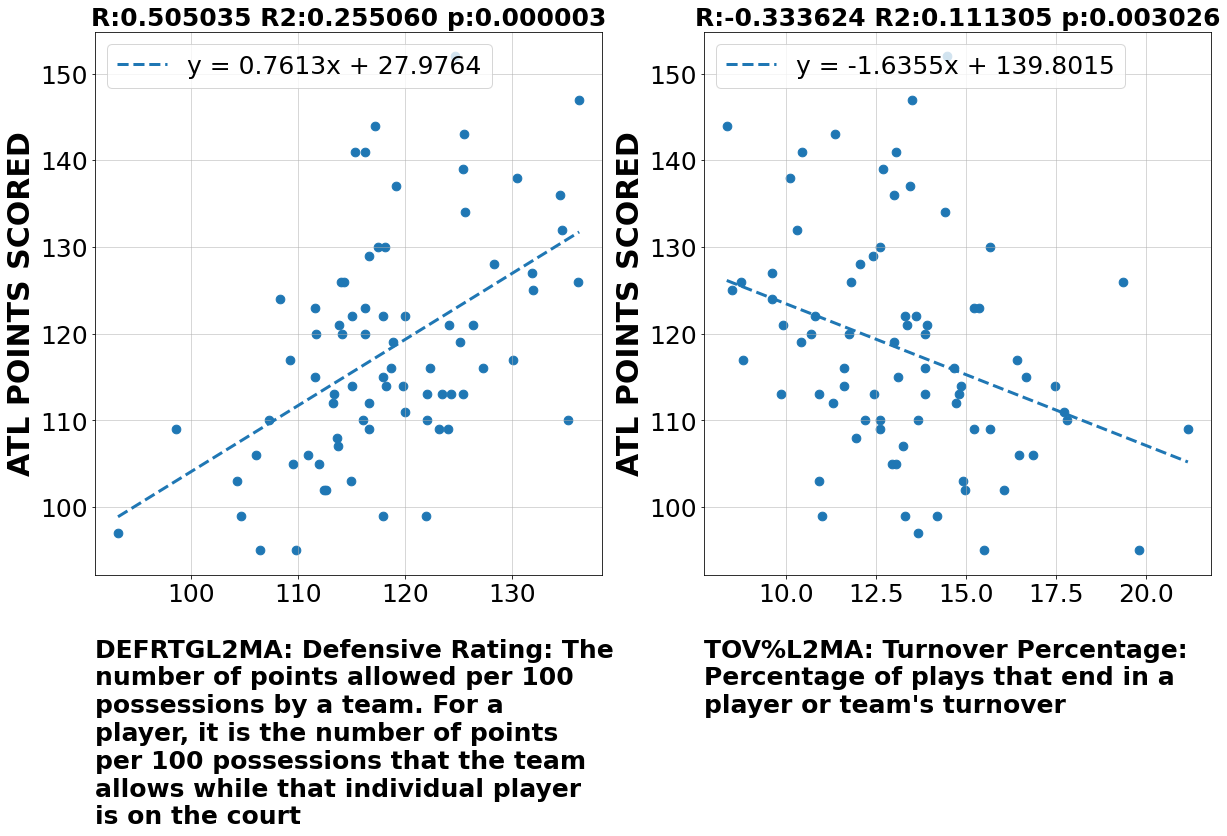

• For Atlanta Hawks games played in 2023-24 NBA Regular Season,
  Feature: Defensive Rating in last 2 games played (DEFRTGL2MA) 
  has strongest correlation to points scored

• For Atlanta Hawks games played in 2023-24 NBA Regular Season,
  Feature: Turnover Percentage in last 2 games played (TOV%L2MA) 
  has weakest correlation to points scored


In [98]:
plotTeamMaxMinFeatureToPointsCorrelation('ATL',NBAdf,leagueCorrelationResultsDF)
printTeamResults('ATL')

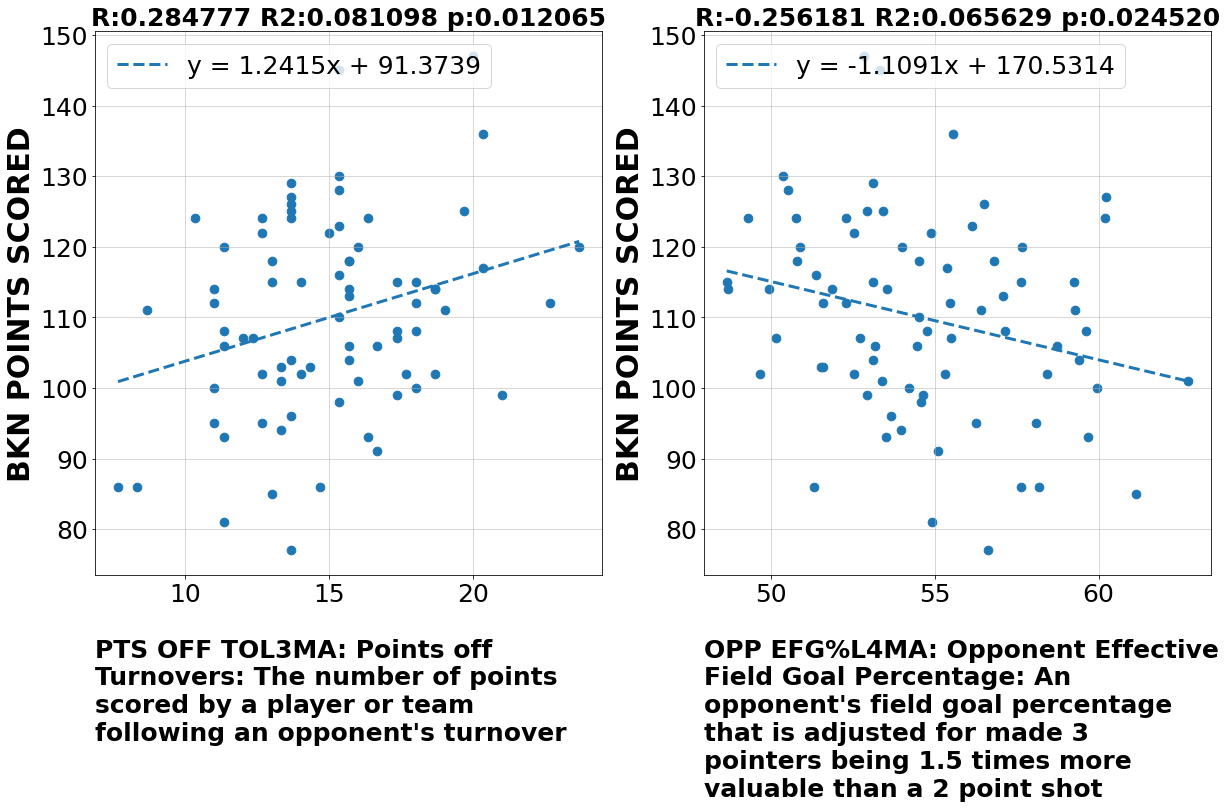

• For Brooklyn Nets games played in 2023-24 NBA Regular Season,
  Feature: Points off Turnovers in last 3 games played (PTS OFF TOL3MA) 
  has strongest correlation to points scored

• For Brooklyn Nets games played in 2023-24 NBA Regular Season,
  Feature: Opponent Effective Field Goal Percentage in last 4 games played (OPP EFG%L4MA) 
  has weakest correlation to points scored


In [99]:
plotTeamMaxMinFeatureToPointsCorrelation('BKN',NBAdf,leagueCorrelationResultsDF)
printTeamResults('BKN')

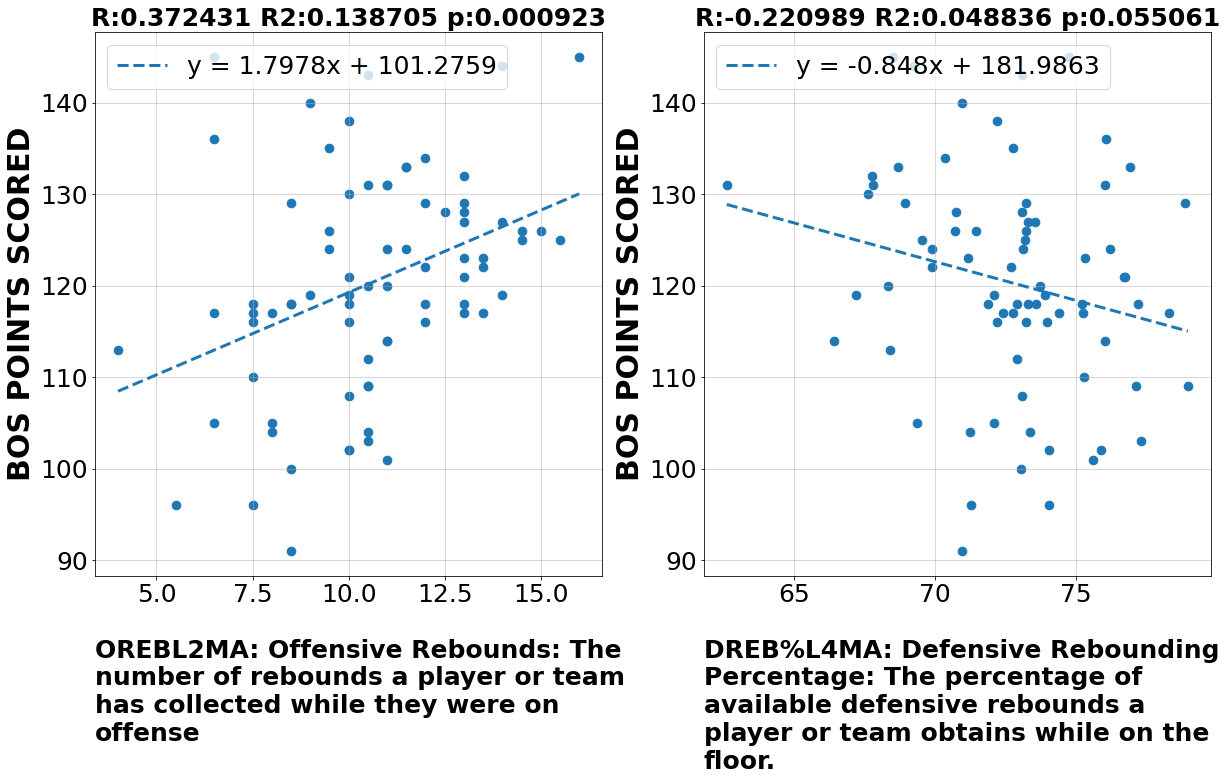

• For Boston Celtics games played in 2023-24 NBA Regular Season,
  Feature: Offensive Rebounds in last 2 games played (OREBL2MA) 
  has strongest correlation to points scored

• For Boston Celtics games played in 2023-24 NBA Regular Season,
  Feature: Defensive Rebounding Percentage in last 4 games played (DREB%L4MA) 
  has weakest correlation to points scored


In [100]:
plotTeamMaxMinFeatureToPointsCorrelation('BOS',NBAdf,leagueCorrelationResultsDF)
printTeamResults('BOS')

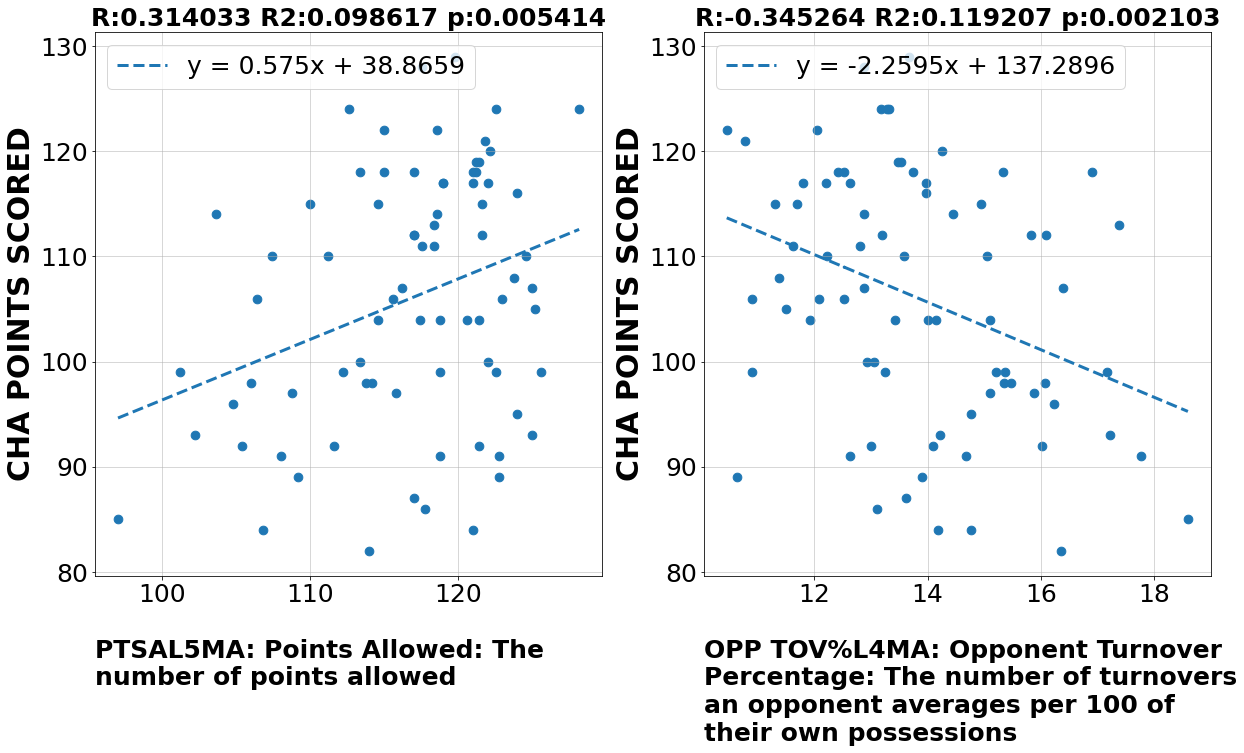

• For Charlotte Hornets games played in 2023-24 NBA Regular Season,
  Feature: Points Allowed in last 5 games played (PTSAL5MA) 
  has strongest correlation to points scored

• For Charlotte Hornets games played in 2023-24 NBA Regular Season,
  Feature: Opponent Turnover Percentage in last 4 games played (OPP TOV%L4MA) 
  has weakest correlation to points scored


In [101]:
plotTeamMaxMinFeatureToPointsCorrelation('CHA',NBAdf,leagueCorrelationResultsDF)
printTeamResults('CHA')

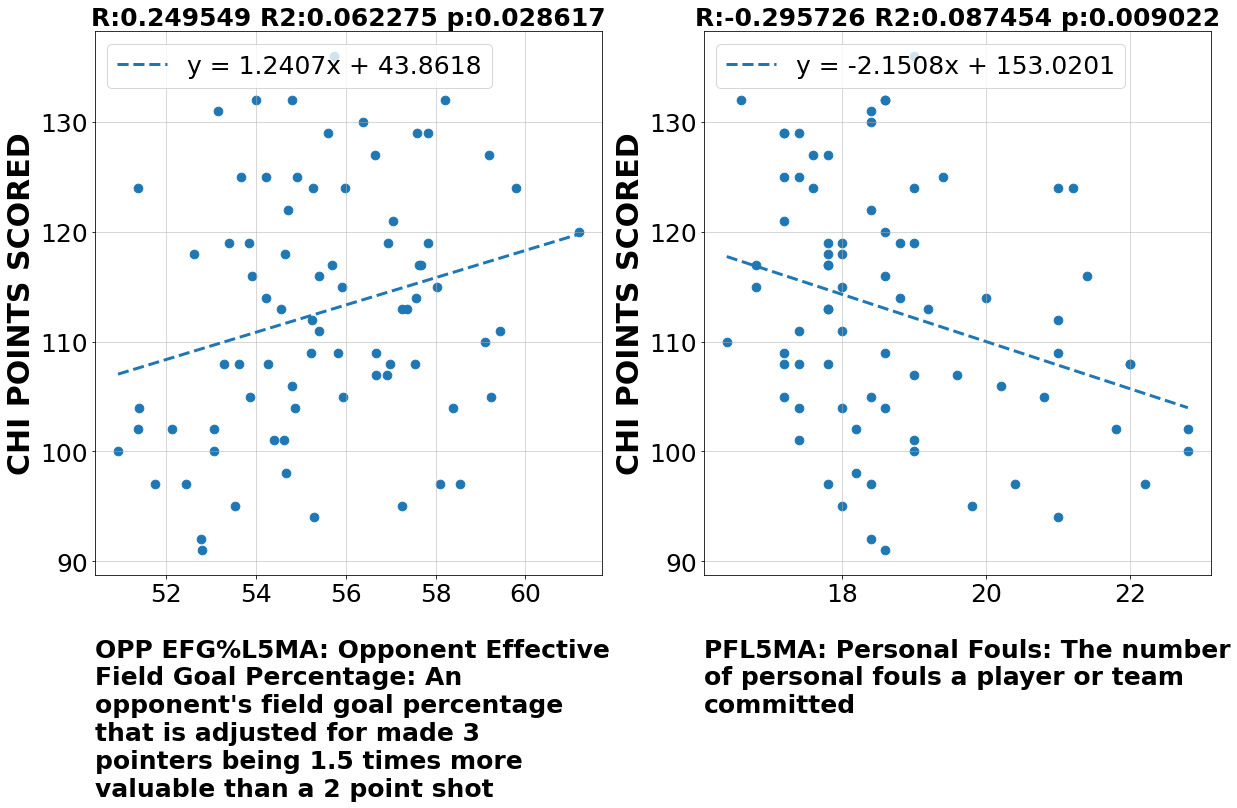

In [102]:
plotTeamMaxMinFeatureToPointsCorrelation('CHI',NBAdf,leagueCorrelationResultsDF)

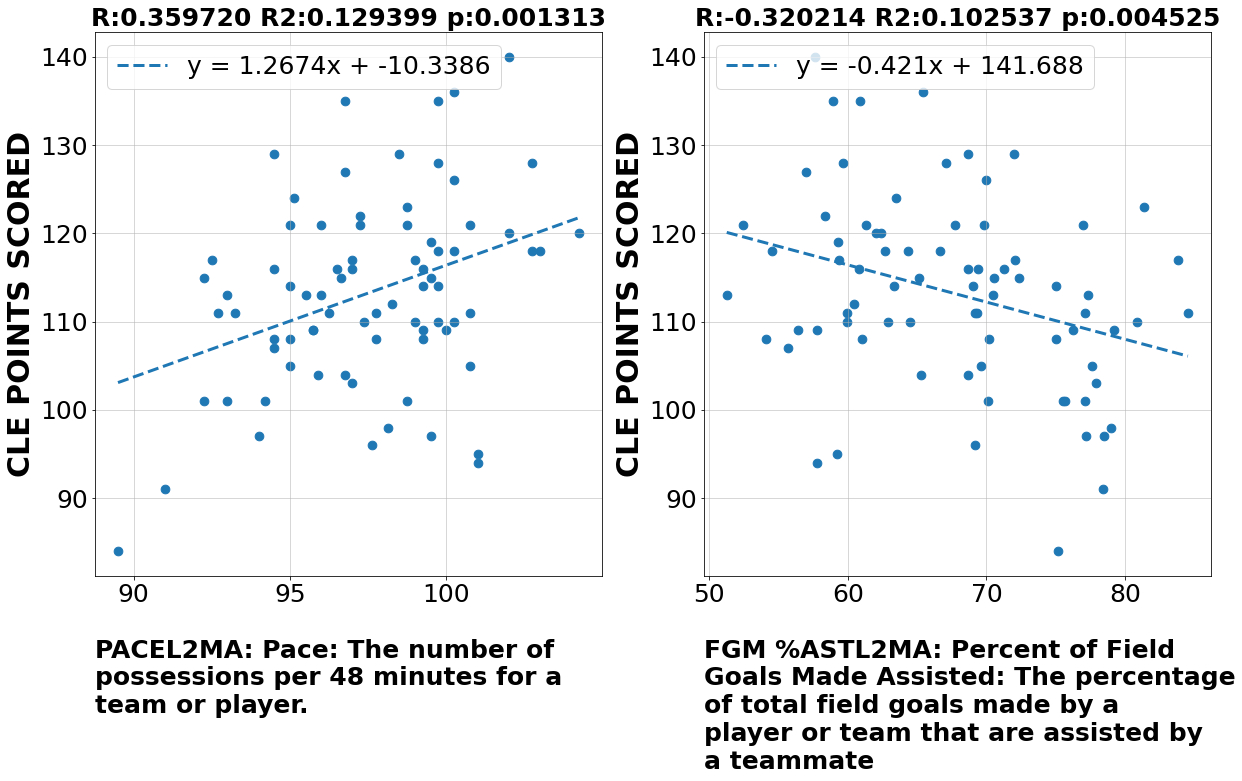

• For Cleveland Cavaliers games played in 2023-24 NBA Regular Season,
  Feature: Pace in last 2 games played (PACEL2MA) 
  has strongest correlation to points scored

• For Cleveland Cavaliers games played in 2023-24 NBA Regular Season,
  Feature: Percent of Field Goals Made Assisted in last 2 games played (FGM %ASTL2MA) 
  has weakest correlation to points scored


In [103]:
plotTeamMaxMinFeatureToPointsCorrelation('CLE',NBAdf,leagueCorrelationResultsDF)
printTeamResults('CLE')

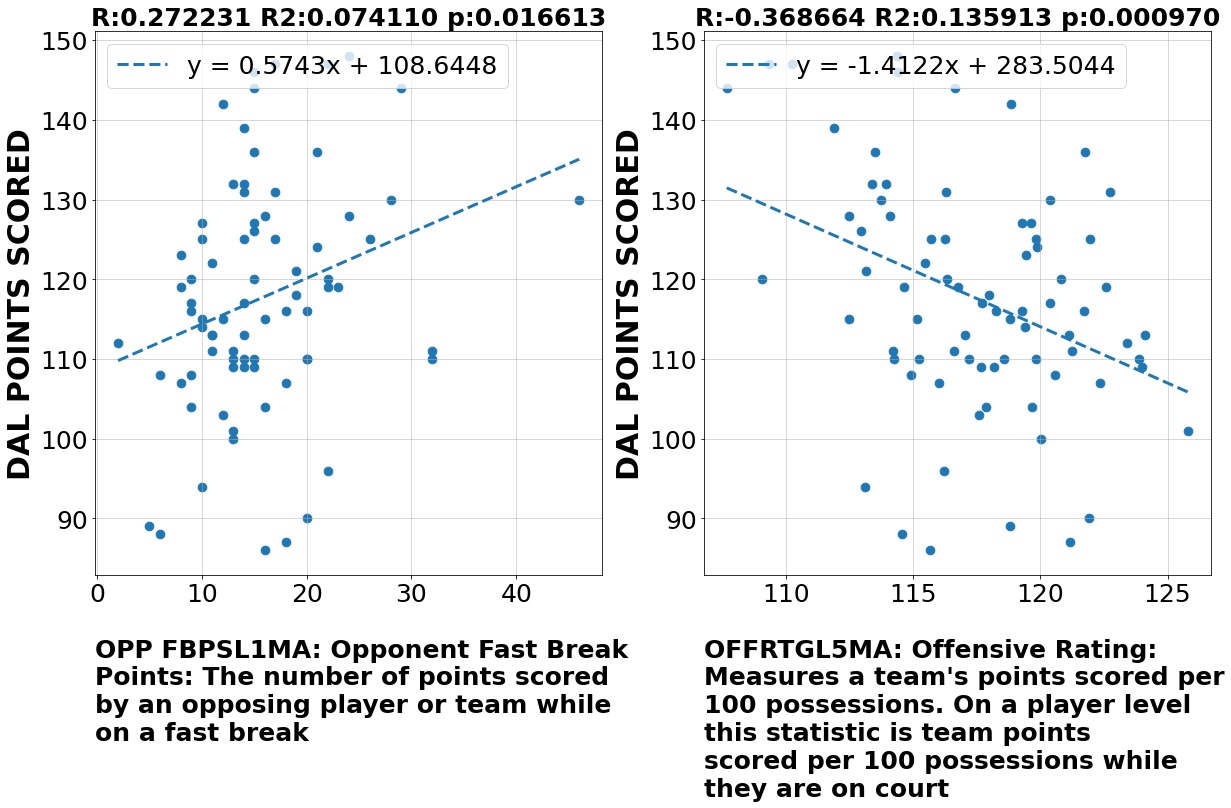

• For Dallas Mavericks games played in 2023-24 NBA Regular Season,
  Feature: Opponent Fast Break Points in last game played feature(OPP FBPSL1MA) 
  has strongest correlation to points scored

• For Dallas Mavericks games played in 2023-24 NBA Regular Season,
  Feature: Offensive Rating in last 5 games played (OFFRTGL5MA) 
  has weakest correlation to points scored


In [104]:
plotTeamMaxMinFeatureToPointsCorrelation('DAL',NBAdf,leagueCorrelationResultsDF)
printTeamResults('DAL')

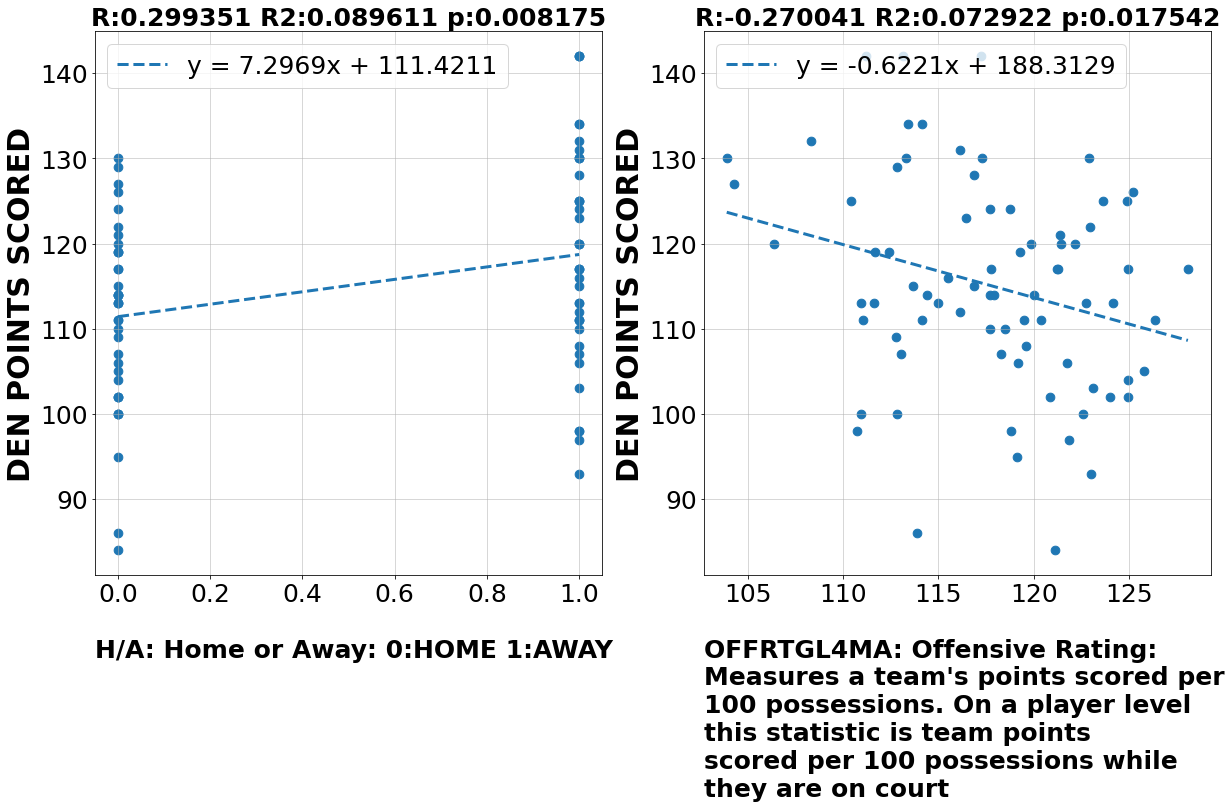

• For Denver Nuggets games played in 2023-24 NBA Regular Season,
  Feature: Home or Away (H/A) 
  has strongest correlation to points scored

• For Denver Nuggets games played in 2023-24 NBA Regular Season,
  Feature: Offensive Rating in last 4 games played (OFFRTGL4MA) 
  has weakest correlation to points scored


In [105]:
plotTeamMaxMinFeatureToPointsCorrelation('DEN',NBAdf,leagueCorrelationResultsDF)
printTeamResults('DEN')

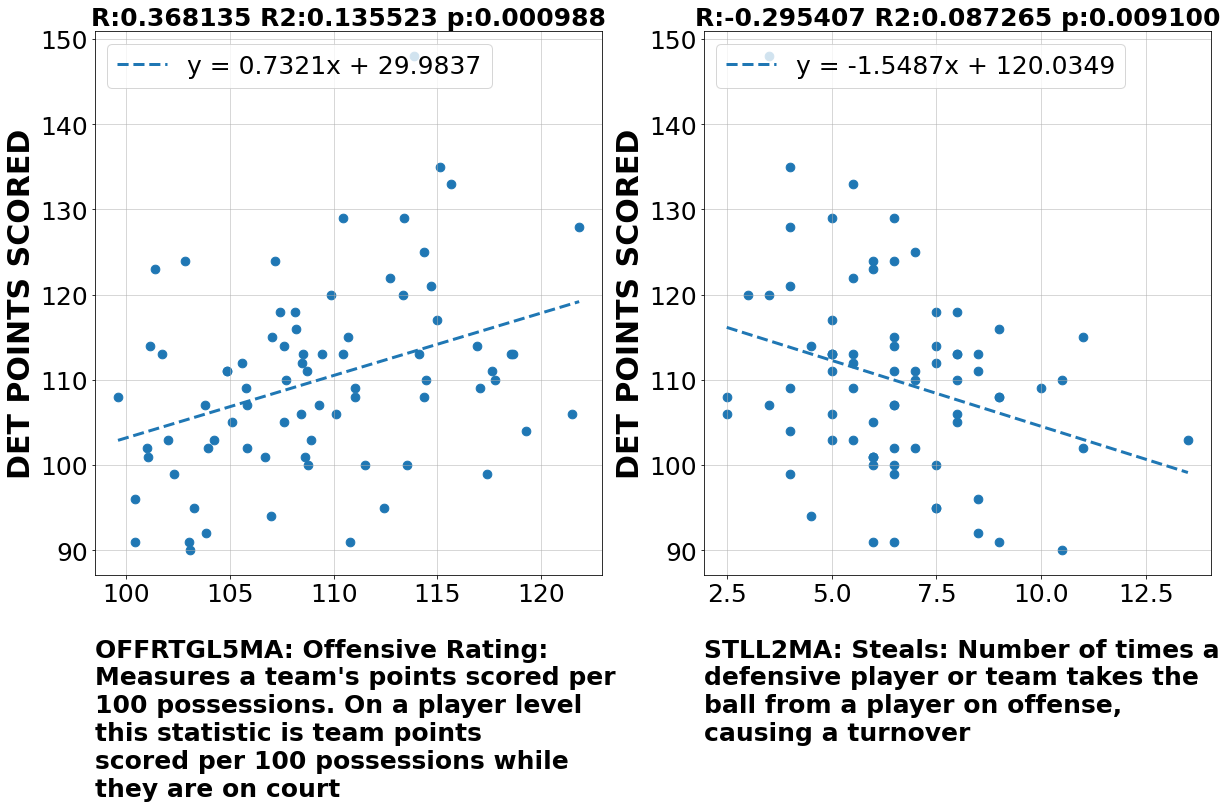

• For Detroit Pistons games played in 2023-24 NBA Regular Season,
  Feature: Offensive Rating in last 5 games played (OFFRTGL5MA) 
  has strongest correlation to points scored

• For Detroit Pistons games played in 2023-24 NBA Regular Season,
  Feature: Steals in last 2 games played (STLL2MA) 
  has weakest correlation to points scored


In [106]:
plotTeamMaxMinFeatureToPointsCorrelation('DET',NBAdf,leagueCorrelationResultsDF)
printTeamResults('DET')

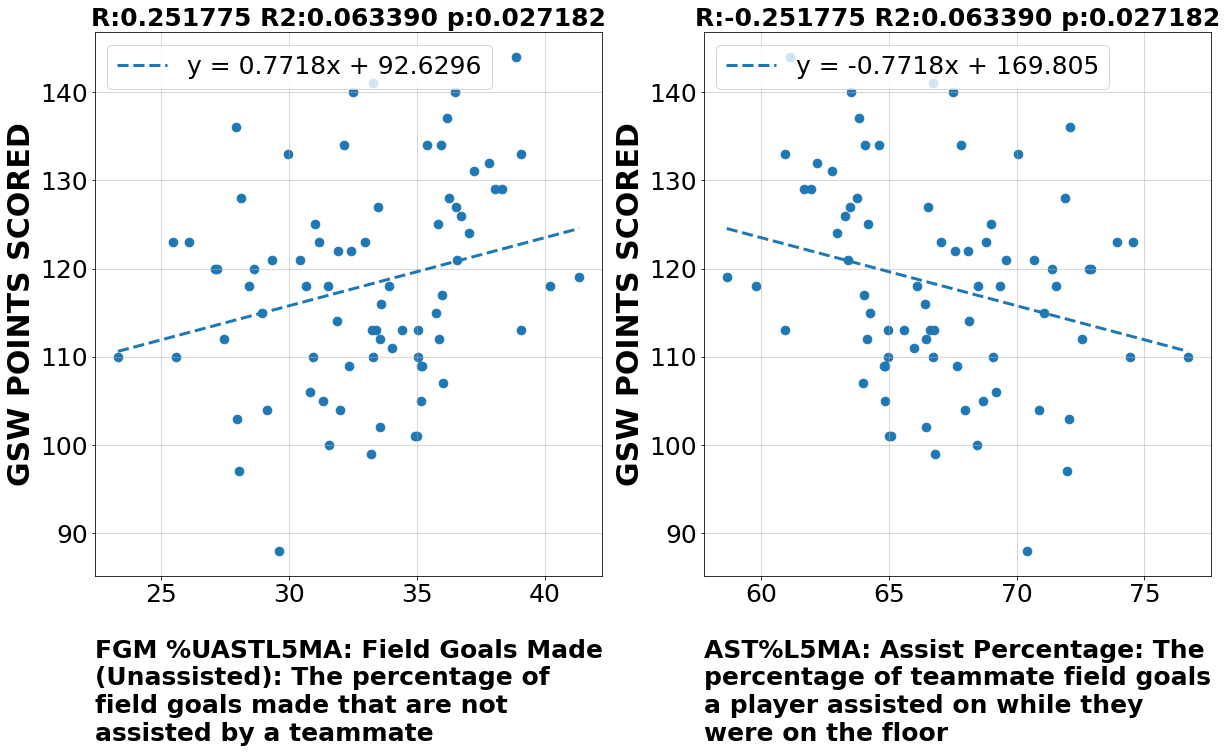

• For Golden State Warriors games played in 2023-24 NBA Regular Season,
  Feature: Field Goals Made (Unassisted) in last 5 games played (FGM %UASTL5MA) 
  has strongest correlation to points scored

• For Golden State Warriors games played in 2023-24 NBA Regular Season,
  Feature: Assist Percentage in last 5 games played (AST%L5MA) 
  has weakest correlation to points scored


In [107]:
plotTeamMaxMinFeatureToPointsCorrelation('GSW',NBAdf,leagueCorrelationResultsDF)
printTeamResults('GSW')

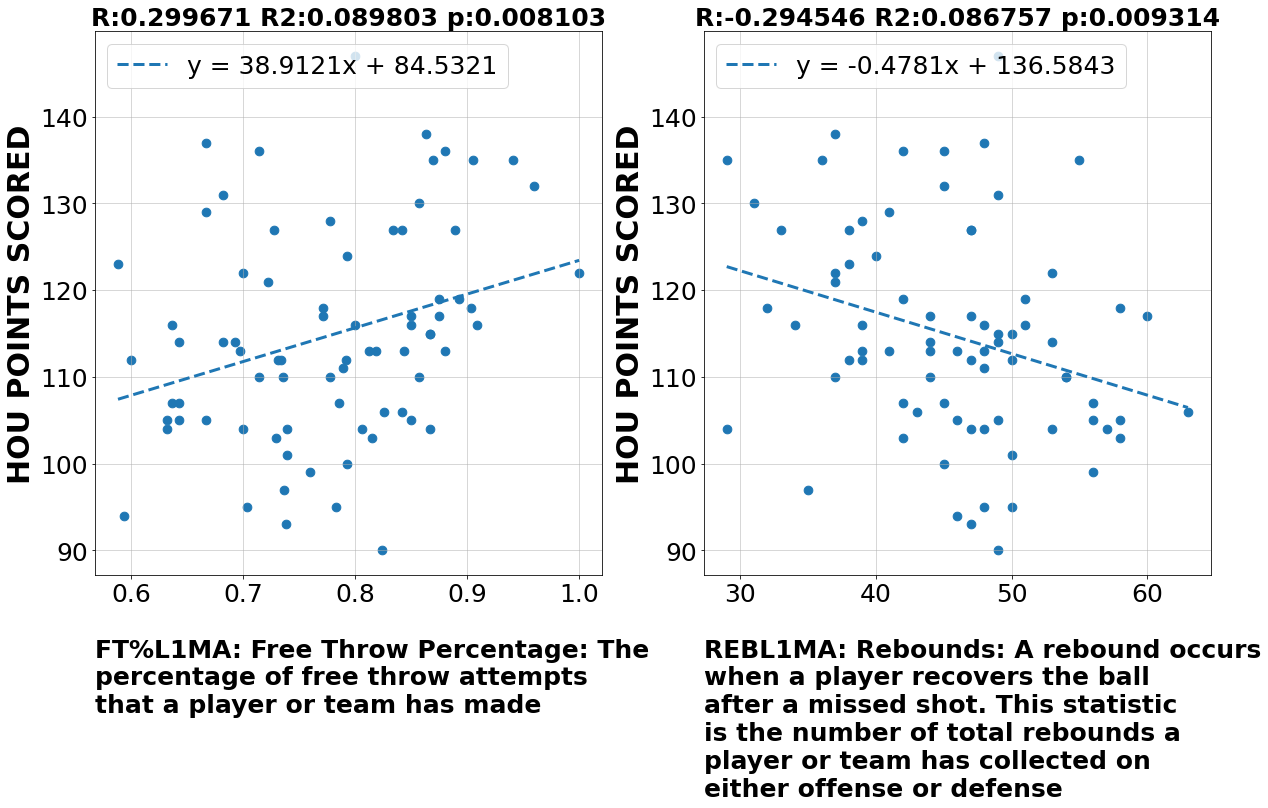

• For Houston Rockets games played in 2023-24 NBA Regular Season,
  Feature: Free Throw Percentage in last game played feature(FT%L1MA) 
  has strongest correlation to points scored

• For Houston Rockets games played in 2023-24 NBA Regular Season,
  Feature: Rebounds in last game played feature(REBL1MA) 
  has weakest correlation to points scored


In [108]:
plotTeamMaxMinFeatureToPointsCorrelation('HOU',NBAdf,leagueCorrelationResultsDF)
printTeamResults('HOU')

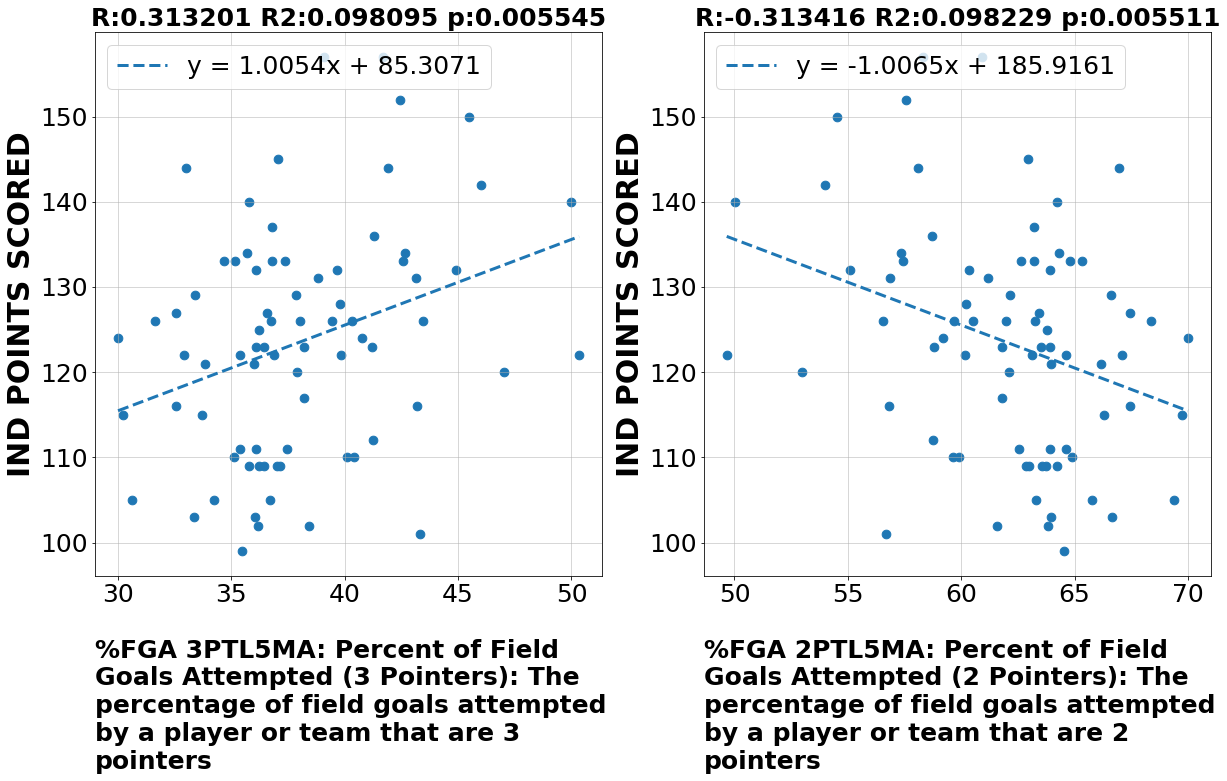

• For Indiana Pacers games played in 2023-24 NBA Regular Season,
  Feature: Percent of Field Goals Attempted (3 Pointers) in last 5 games played (%FGA 3PTL5MA) 
  has strongest correlation to points scored

• For Indiana Pacers games played in 2023-24 NBA Regular Season,
  Feature: Percent of Field Goals Attempted (2 Pointers) in last 5 games played (%FGA 2PTL5MA) 
  has weakest correlation to points scored


In [109]:
plotTeamMaxMinFeatureToPointsCorrelation('IND',NBAdf,leagueCorrelationResultsDF)
printTeamResults('IND')

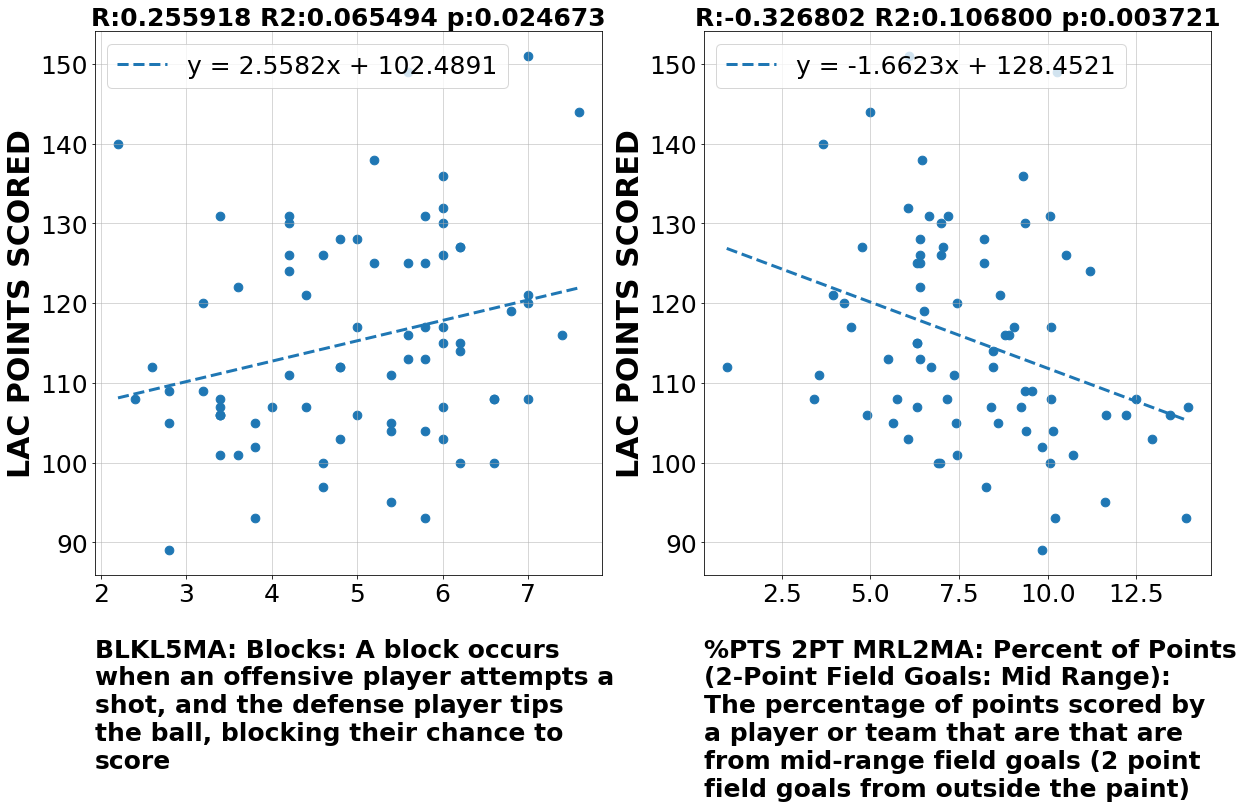

• For Los Angeles Clippers games played in 2023-24 NBA Regular Season,
  Feature: Blocks in last 5 games played (BLKL5MA) 
  has strongest correlation to points scored

• For Los Angeles Clippers games played in 2023-24 NBA Regular Season,
  Feature: Percent of Points (2-Point Field Goals: Mid Range) in last 2 games played (%PTS 2PT MRL2MA) 
  has weakest correlation to points scored


In [110]:
plotTeamMaxMinFeatureToPointsCorrelation('LAC',NBAdf,leagueCorrelationResultsDF)
printTeamResults('LAC')

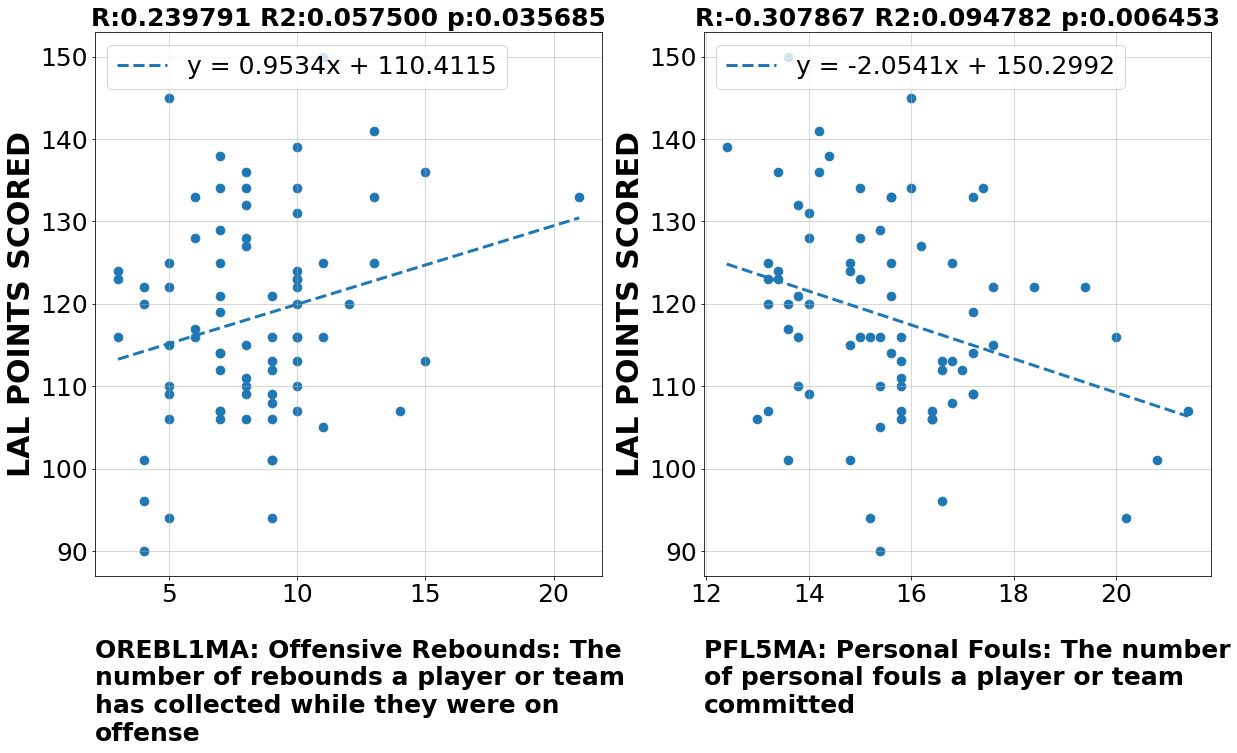

• For Los Angeles Lakers games played in 2023-24 NBA Regular Season,
  Feature: Offensive Rebounds in last game played feature(OREBL1MA) 
  has strongest correlation to points scored

• For Los Angeles Lakers games played in 2023-24 NBA Regular Season,
  Feature: Personal Fouls in last 5 games played (PFL5MA) 
  has weakest correlation to points scored


In [111]:
plotTeamMaxMinFeatureToPointsCorrelation('LAL',NBAdf,leagueCorrelationResultsDF)
printTeamResults('LAL')

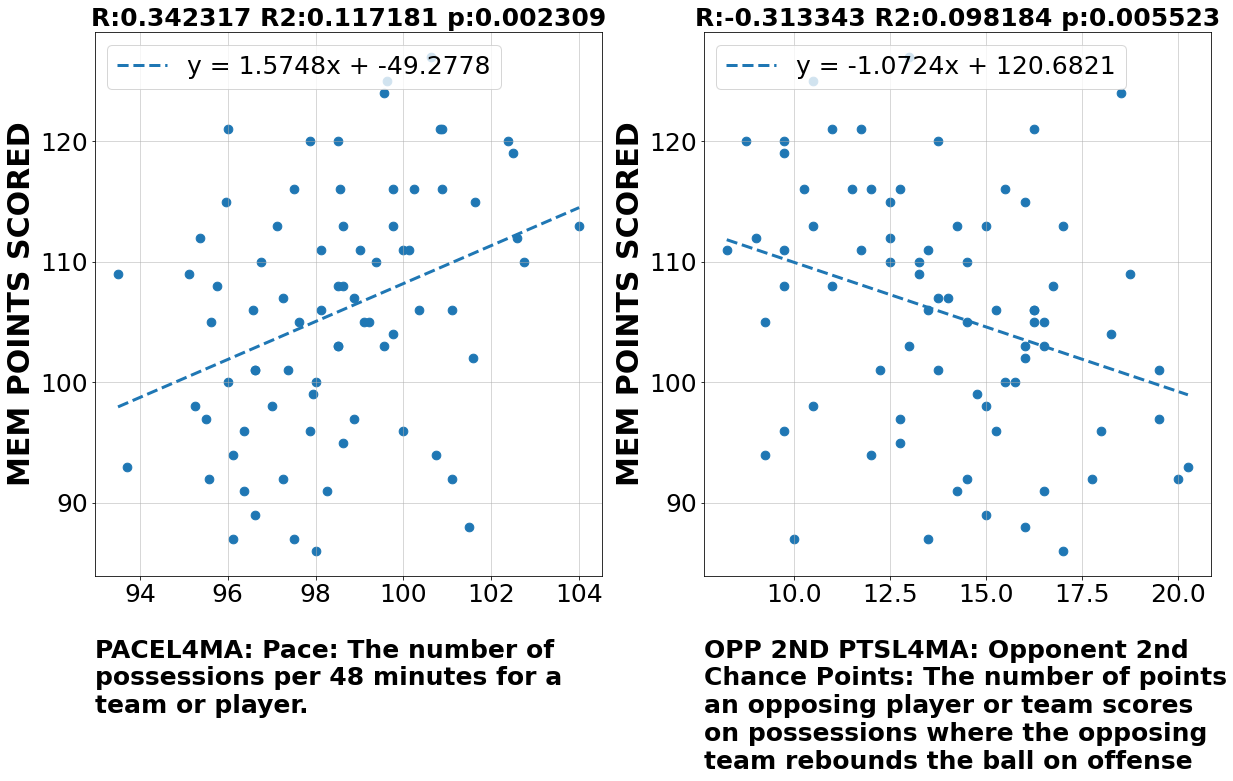

• For Memphis Grizzlies games played in 2023-24 NBA Regular Season,
  Feature: Pace in last 4 games played (PACEL4MA) 
  has strongest correlation to points scored

• For Memphis Grizzlies games played in 2023-24 NBA Regular Season,
  Feature: Opponent 2nd Chance Points in last 4 games played (OPP 2ND PTSL4MA) 
  has weakest correlation to points scored


In [112]:
plotTeamMaxMinFeatureToPointsCorrelation('MEM',NBAdf,leagueCorrelationResultsDF)
printTeamResults('MEM')

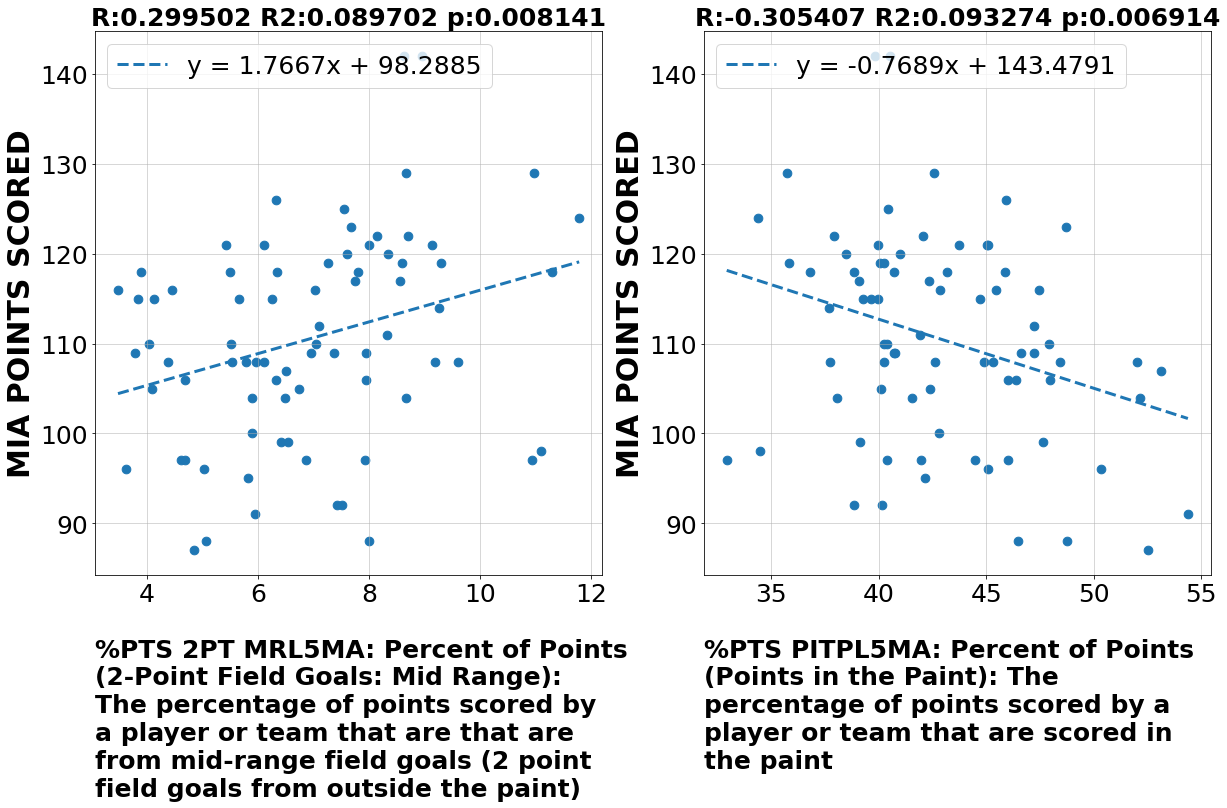

• For Miami Heat games played in 2023-24 NBA Regular Season,
  Feature: Percent of Points (2-Point Field Goals: Mid Range) in last 5 games played (%PTS 2PT MRL5MA) 
  has strongest correlation to points scored

• For Miami Heat games played in 2023-24 NBA Regular Season,
  Feature: Percent of Points (Points in the Paint) in last 5 games played (%PTS PITPL5MA) 
  has weakest correlation to points scored


In [113]:
plotTeamMaxMinFeatureToPointsCorrelation('MIA',NBAdf,leagueCorrelationResultsDF)
printTeamResults('MIA')

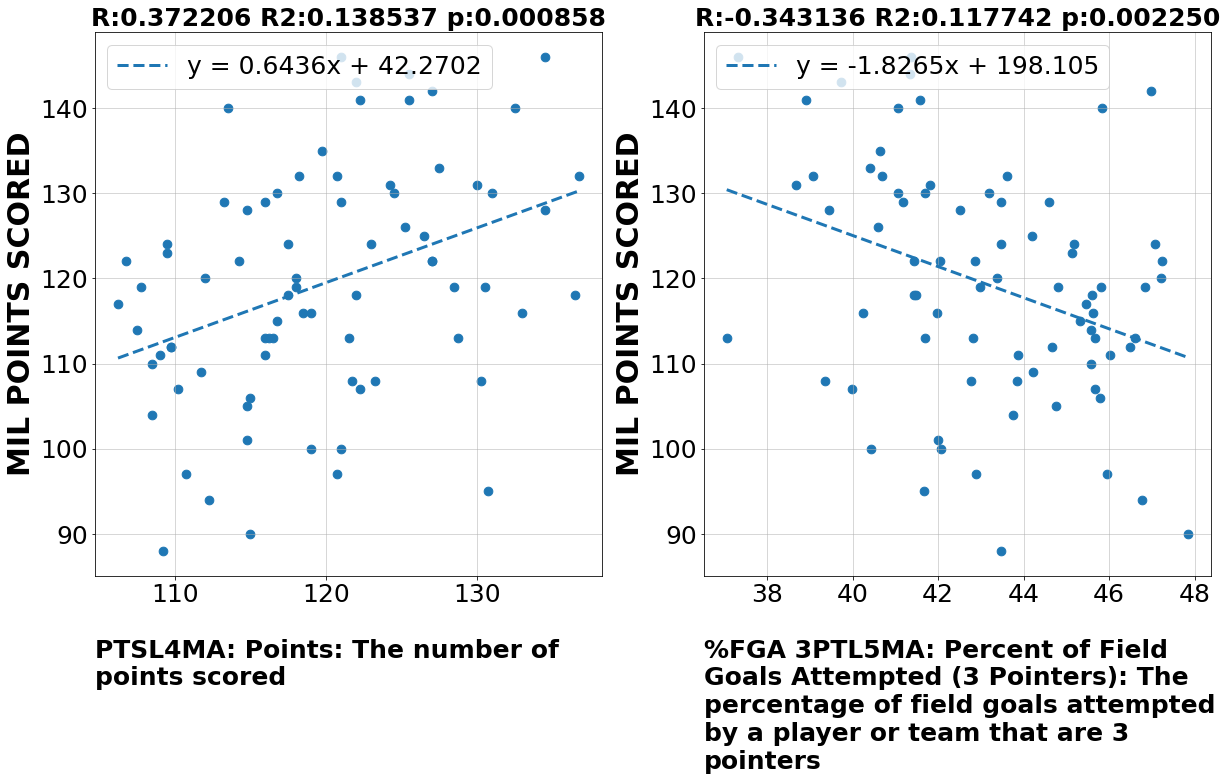

• For Milwaukee Bucks games played in 2023-24 NBA Regular Season,
  Feature: Points in last 4 games played (PTSL4MA) 
  has strongest correlation to points scored

• For Milwaukee Bucks games played in 2023-24 NBA Regular Season,
  Feature: Percent of Field Goals Attempted (3 Pointers) in last 5 games played (%FGA 3PTL5MA) 
  has weakest correlation to points scored


In [114]:
plotTeamMaxMinFeatureToPointsCorrelation('MIL',NBAdf,leagueCorrelationResultsDF)
printTeamResults('MIL')

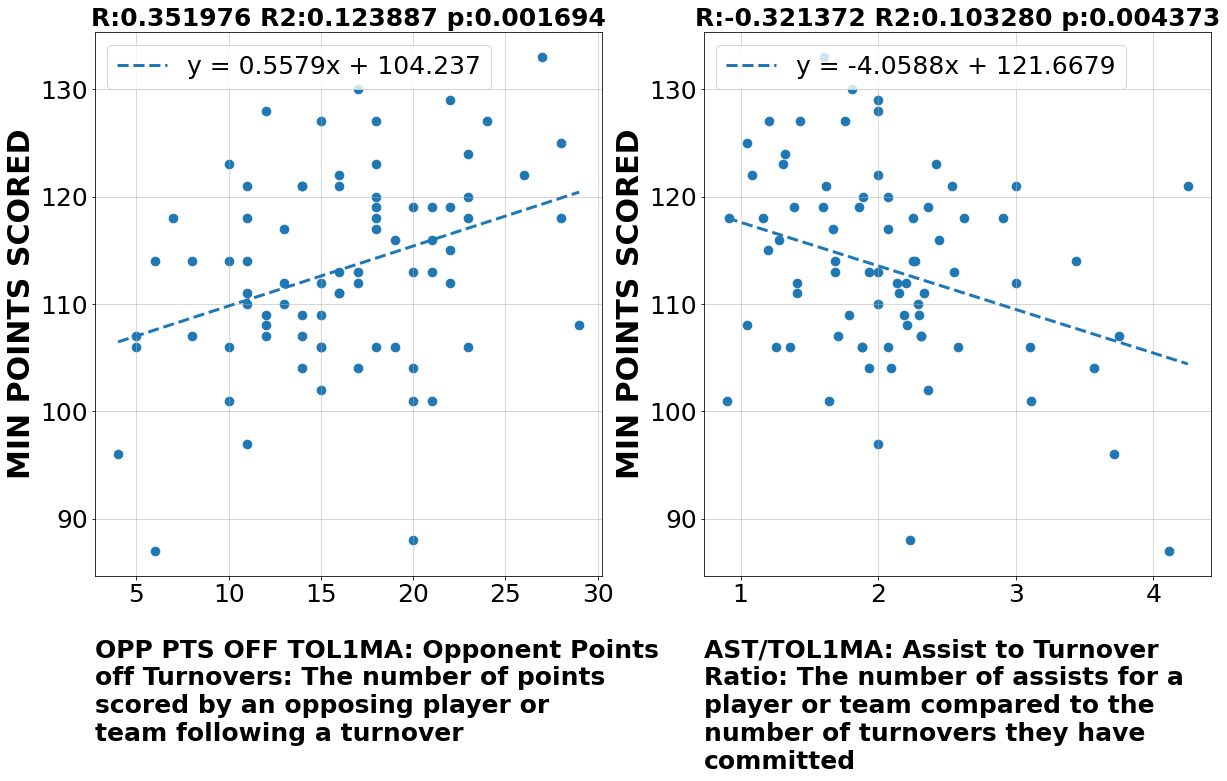

• For Minnesota Timberwolves games played in 2023-24 NBA Regular Season,
  Feature: Opponent Points off Turnovers in last game played feature(OPP PTS OFF TOL1MA) 
  has strongest correlation to points scored

• For Minnesota Timberwolves games played in 2023-24 NBA Regular Season,
  Feature: Assist to Turnover Ratio in last game played feature(AST/TOL1MA) 
  has weakest correlation to points scored


In [116]:
plotTeamMaxMinFeatureToPointsCorrelation('MIN',NBAdf,leagueCorrelationResultsDF)
printTeamResults('MIN')

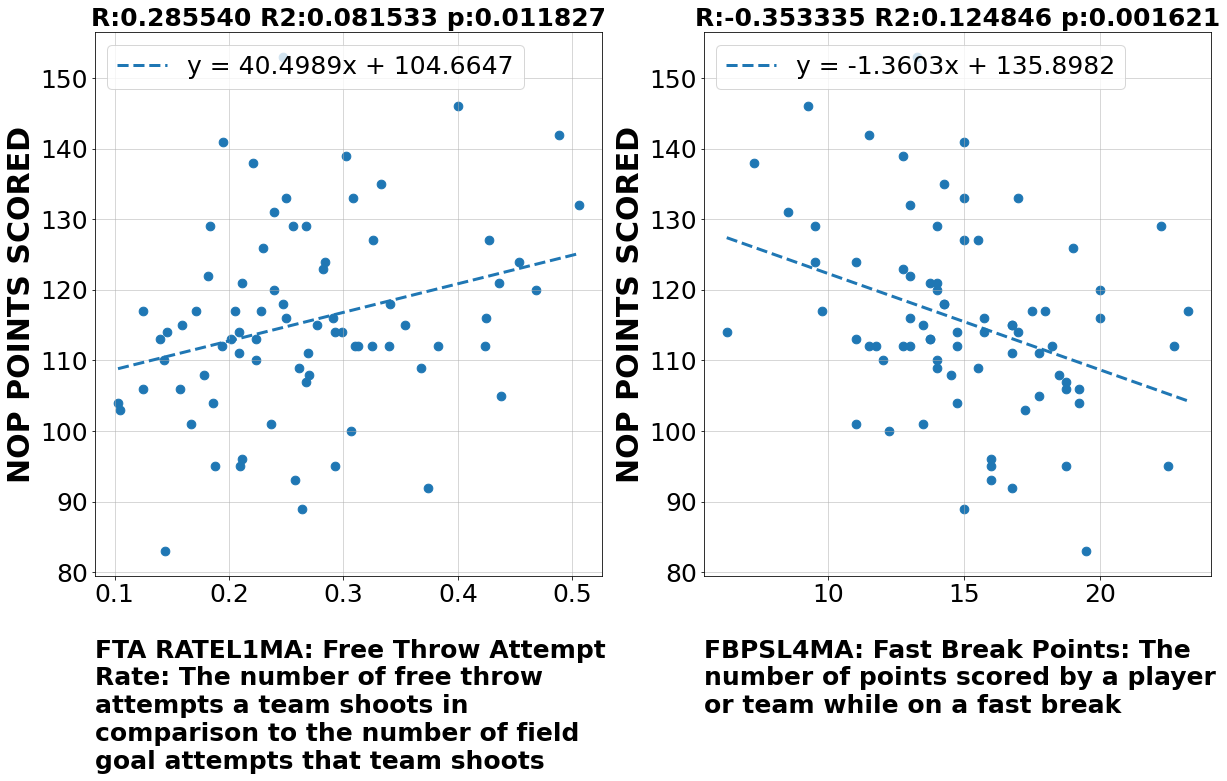

• For New Orleans Pelicans games played in 2023-24 NBA Regular Season,
  Feature: Free Throw Attempt Rate in last game played feature(FTA RATEL1MA) 
  has strongest correlation to points scored

• For New Orleans Pelicans games played in 2023-24 NBA Regular Season,
  Feature: Fast Break Points in last 4 games played (FBPSL4MA) 
  has weakest correlation to points scored


In [117]:
plotTeamMaxMinFeatureToPointsCorrelation('NOP',NBAdf,leagueCorrelationResultsDF)
printTeamResults('NOP')

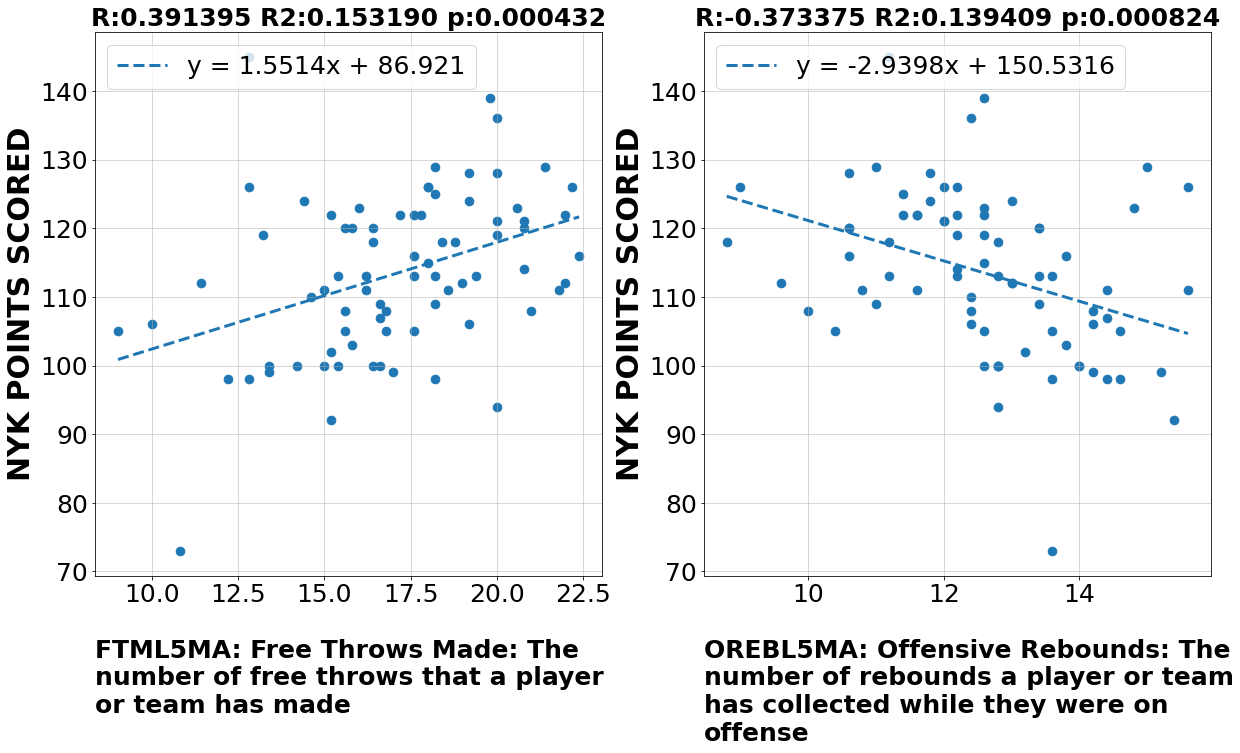

• For New York Knicks games played in 2023-24 NBA Regular Season,
  Feature: Free Throws Made in last 5 games played (FTML5MA) 
  has strongest correlation to points scored

• For New York Knicks games played in 2023-24 NBA Regular Season,
  Feature: Offensive Rebounds in last 5 games played (OREBL5MA) 
  has weakest correlation to points scored


In [118]:
plotTeamMaxMinFeatureToPointsCorrelation('NYK',NBAdf,leagueCorrelationResultsDF)
printTeamResults('NYK')

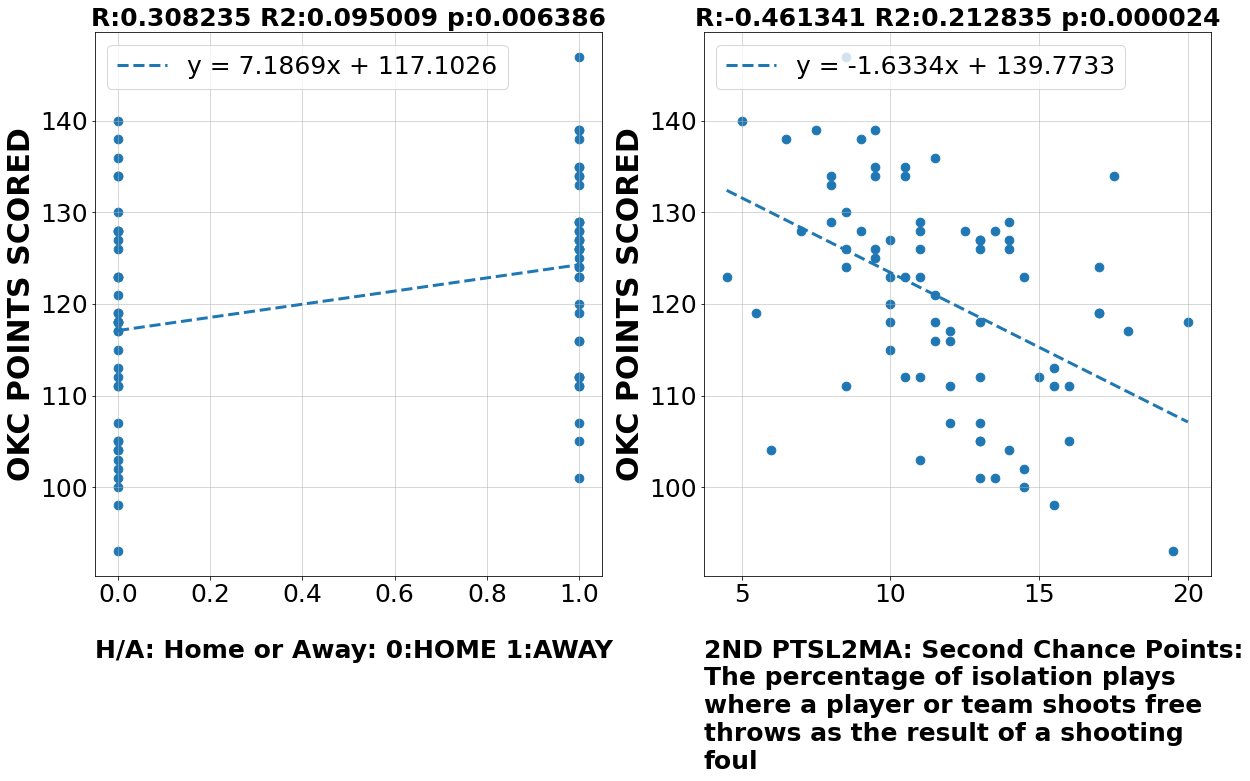

• For Oklahoma City Thunder games played in 2023-24 NBA Regular Season,
  Feature: Home or Away (H/A) 
  has strongest correlation to points scored

• For Oklahoma City Thunder games played in 2023-24 NBA Regular Season,
  Feature: Second Chance Points in last 2 games played (2ND PTSL2MA) 
  has weakest correlation to points scored


In [119]:
plotTeamMaxMinFeatureToPointsCorrelation('OKC',NBAdf,leagueCorrelationResultsDF)
printTeamResults('OKC')

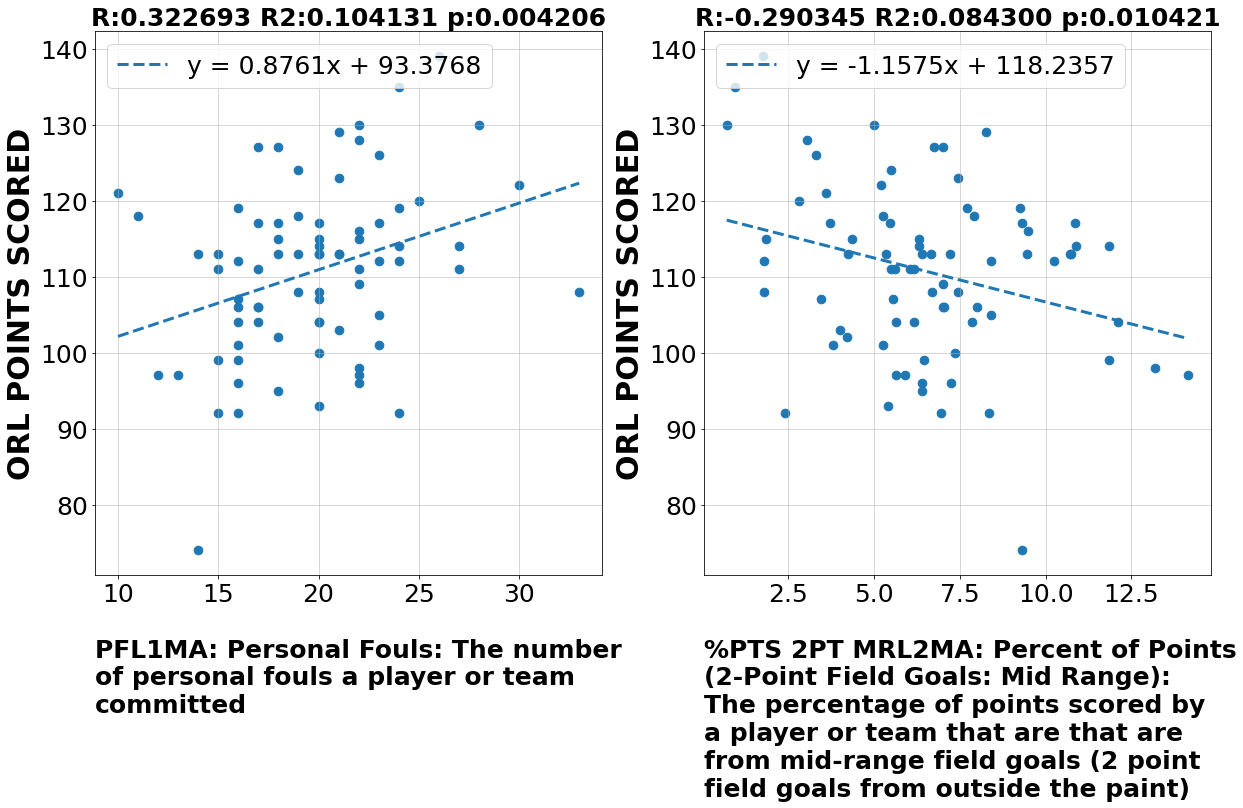

• For Orlando Magic games played in 2023-24 NBA Regular Season,
  Feature: Personal Fouls in last game played feature(PFL1MA) 
  has strongest correlation to points scored

• For Orlando Magic games played in 2023-24 NBA Regular Season,
  Feature: Percent of Points (2-Point Field Goals: Mid Range) in last 2 games played (%PTS 2PT MRL2MA) 
  has weakest correlation to points scored


In [120]:
plotTeamMaxMinFeatureToPointsCorrelation('ORL',NBAdf,leagueCorrelationResultsDF)
printTeamResults('ORL')

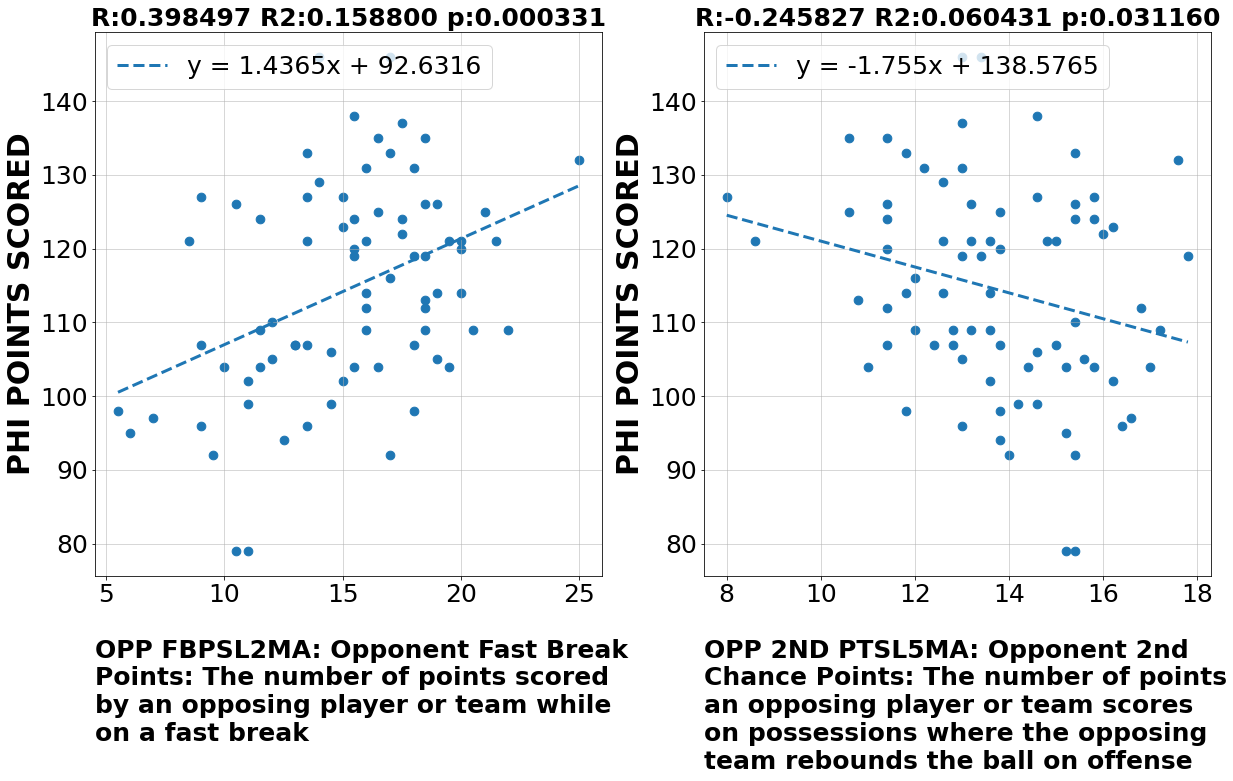

• For Philadelphia 76ers games played in 2023-24 NBA Regular Season,
  Feature: Opponent Fast Break Points in last 2 games played (OPP FBPSL2MA) 
  has strongest correlation to points scored

• For Philadelphia 76ers games played in 2023-24 NBA Regular Season,
  Feature: Opponent 2nd Chance Points in last 5 games played (OPP 2ND PTSL5MA) 
  has weakest correlation to points scored


In [121]:
plotTeamMaxMinFeatureToPointsCorrelation('PHI',NBAdf,leagueCorrelationResultsDF)
printTeamResults('PHI')

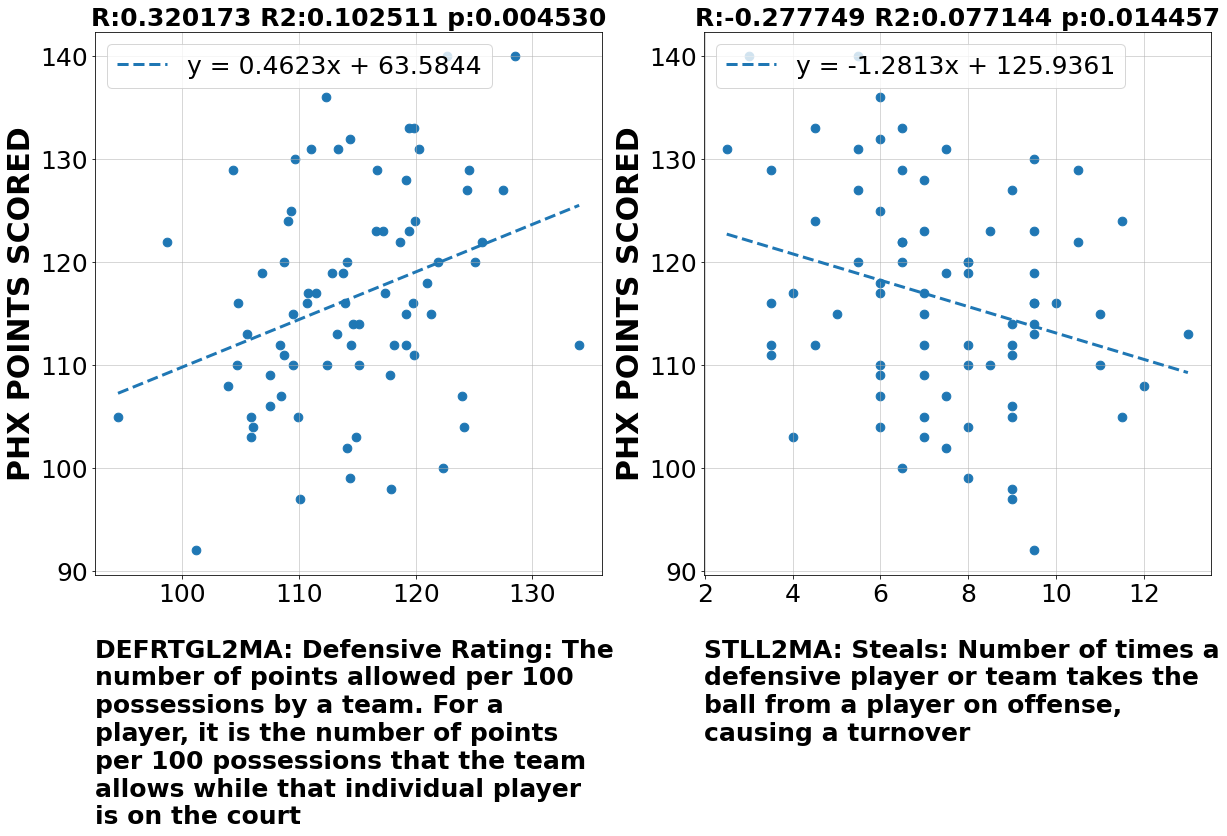

In [122]:
plotTeamMaxMinFeatureToPointsCorrelation('PHX',NBAdf,leagueCorrelationResultsDF)

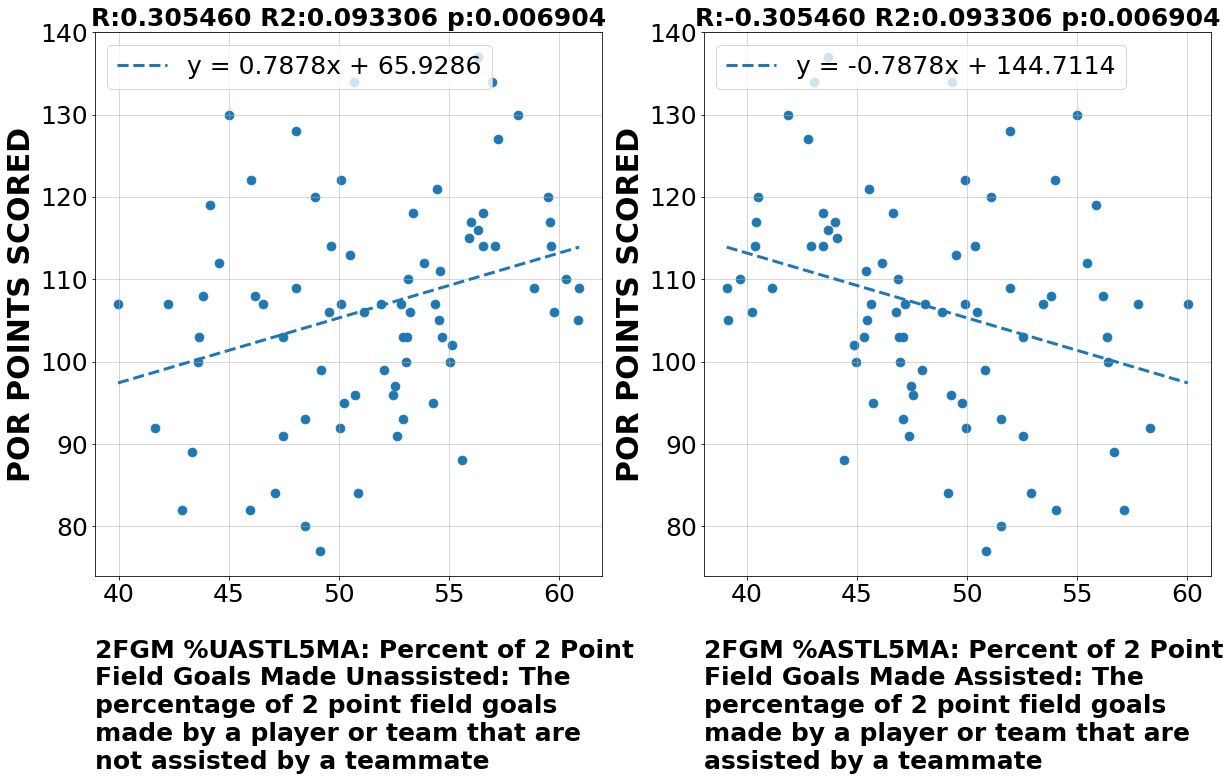

• For Portland Trail Blazers games played in 2023-24 NBA Regular Season,
  Feature: Percent of 2 Point Field Goals Made Unassisted in last 5 games played (2FGM %UASTL5MA) 
  has strongest correlation to points scored

• For Portland Trail Blazers games played in 2023-24 NBA Regular Season,
  Feature: Percent of 2 Point Field Goals Made Assisted in last 5 games played (2FGM %ASTL5MA) 
  has weakest correlation to points scored


In [123]:
plotTeamMaxMinFeatureToPointsCorrelation('POR',NBAdf,leagueCorrelationResultsDF)
printTeamResults('POR')

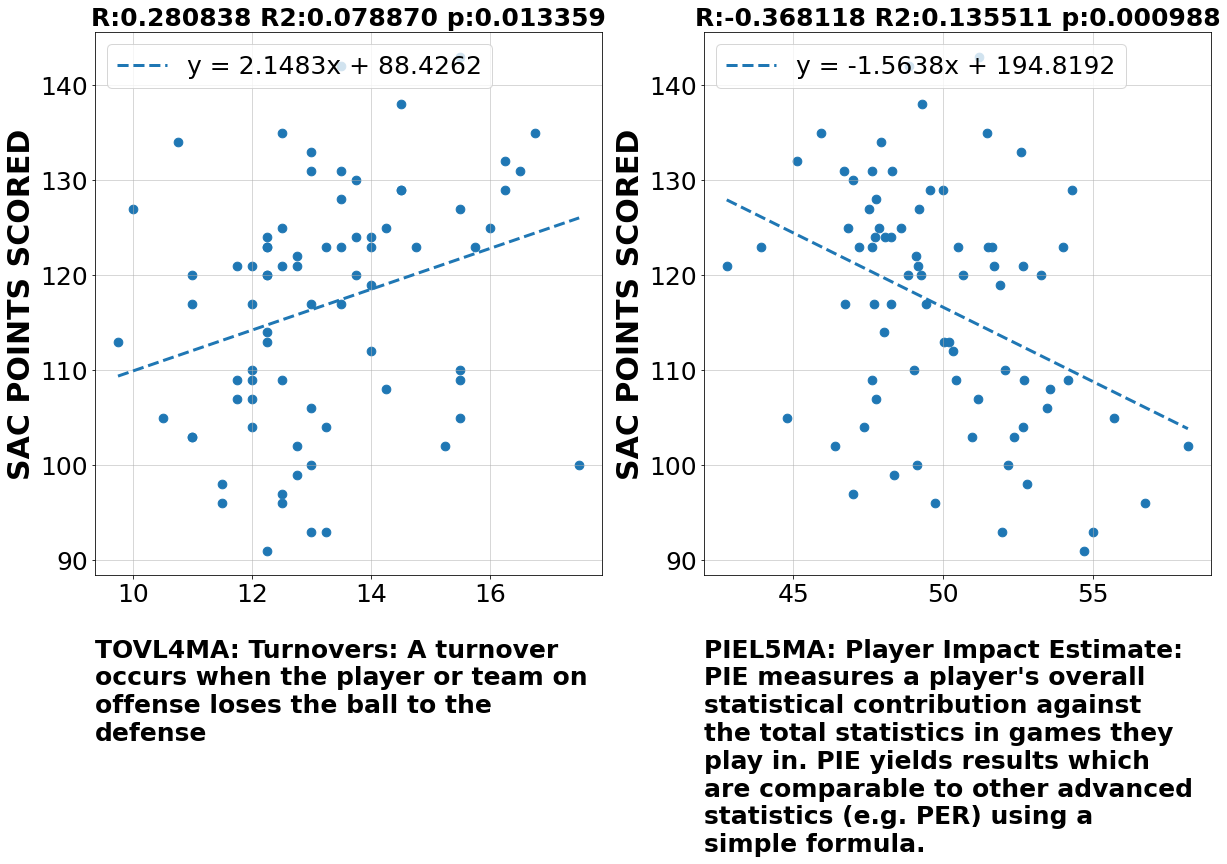

• For Sacramento Kings games played in 2023-24 NBA Regular Season,
  Feature: Turnovers in last 4 games played (TOVL4MA) 
  has strongest correlation to points scored

• For Sacramento Kings games played in 2023-24 NBA Regular Season,
  Feature: Player Impact Estimate in last 5 games played (PIEL5MA) 
  has weakest correlation to points scored


In [124]:
plotTeamMaxMinFeatureToPointsCorrelation('SAC',NBAdf,leagueCorrelationResultsDF)
printTeamResults('SAC')

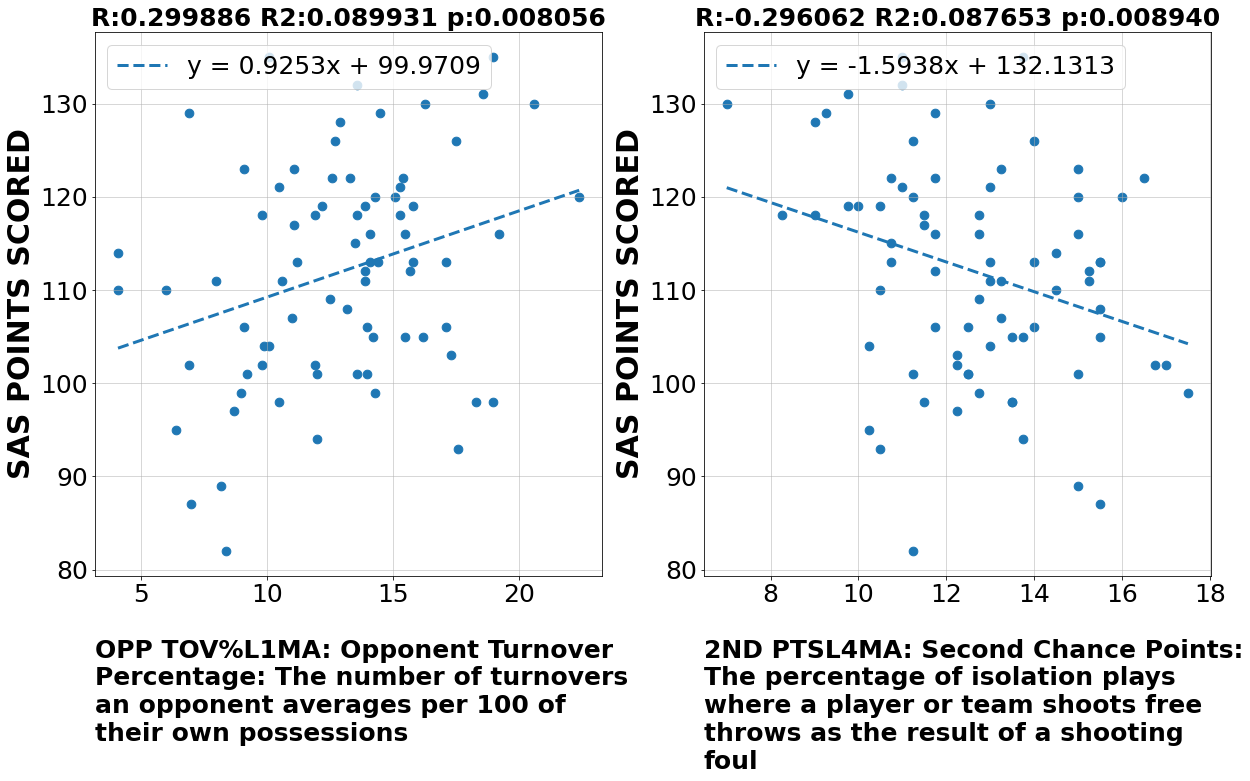

• For San Antonio Spurs games played in 2023-24 NBA Regular Season,
  Feature: Opponent Turnover Percentage in last game played feature(OPP TOV%L1MA) 
  has strongest correlation to points scored

• For San Antonio Spurs games played in 2023-24 NBA Regular Season,
  Feature: Second Chance Points in last 4 games played (2ND PTSL4MA) 
  has weakest correlation to points scored


In [125]:
plotTeamMaxMinFeatureToPointsCorrelation('SAS',NBAdf,leagueCorrelationResultsDF)
printTeamResults('SAS')

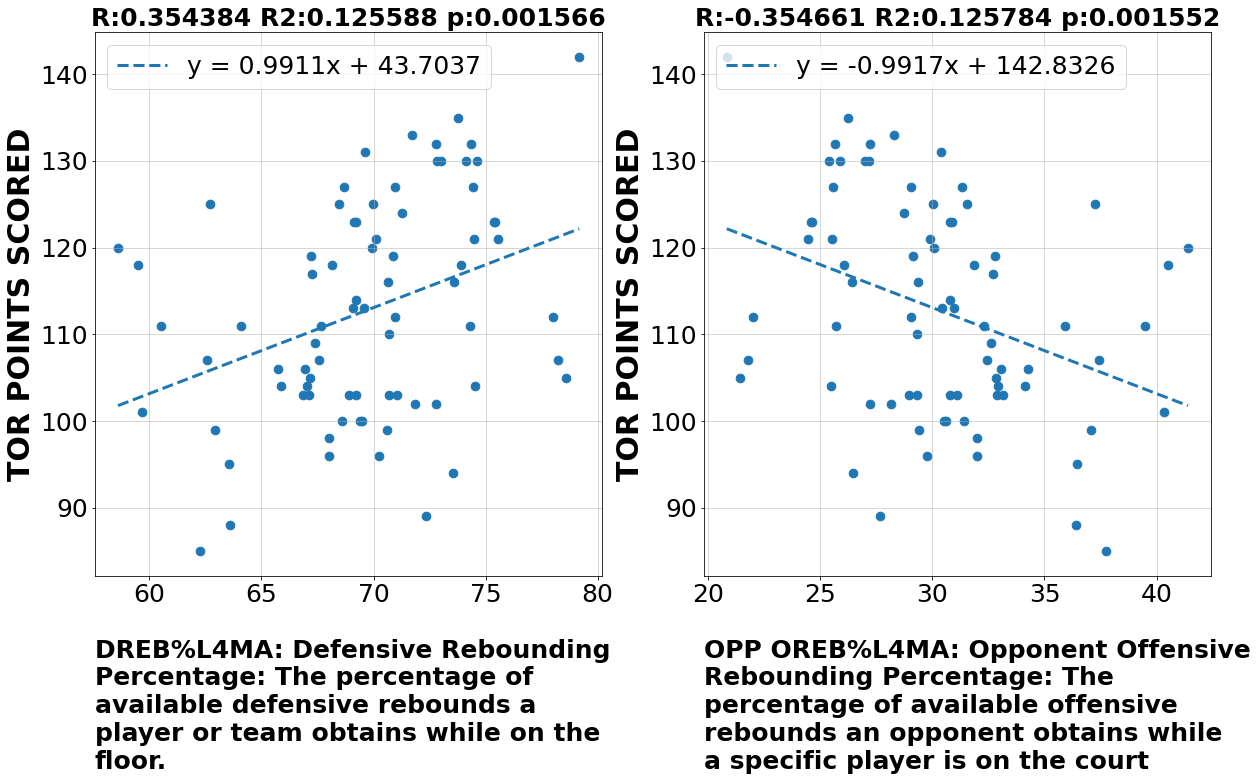

• For Toronto Raptors games played in 2023-24 NBA Regular Season,
  Feature: Defensive Rebounding Percentage in last 4 games played (DREB%L4MA) 
  has strongest correlation to points scored

• For Toronto Raptors games played in 2023-24 NBA Regular Season,
  Feature: Opponent Offensive Rebounding Percentage in last 4 games played (OPP OREB%L4MA) 
  has weakest correlation to points scored


In [126]:
plotTeamMaxMinFeatureToPointsCorrelation('TOR',NBAdf,leagueCorrelationResultsDF)
printTeamResults('TOR')

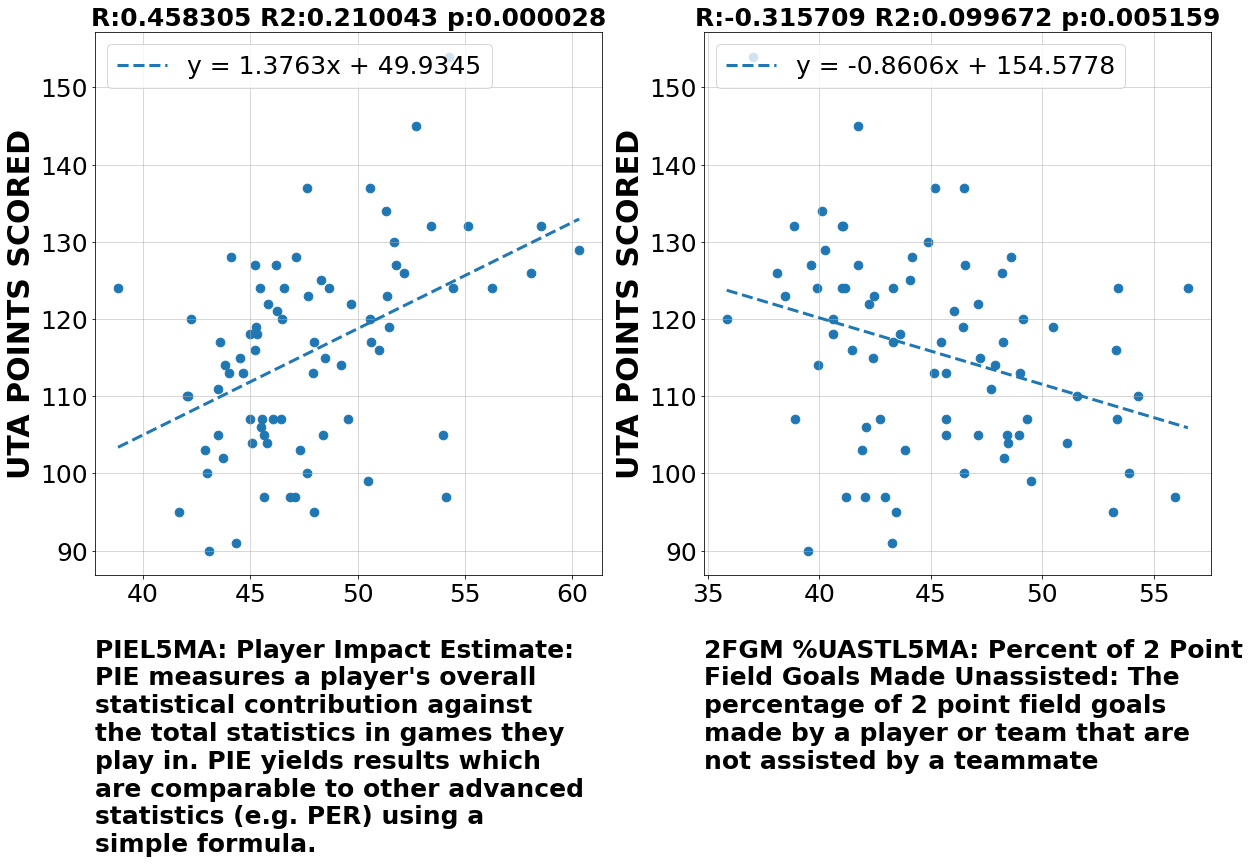

• For Utah Jazz games played in 2023-24 NBA Regular Season,
  Feature: Player Impact Estimate in last 5 games played (PIEL5MA) 
  has strongest correlation to points scored

• For Utah Jazz games played in 2023-24 NBA Regular Season,
  Feature: Percent of 2 Point Field Goals Made Unassisted in last 5 games played (2FGM %UASTL5MA) 
  has weakest correlation to points scored


In [127]:
plotTeamMaxMinFeatureToPointsCorrelation('UTA',NBAdf,leagueCorrelationResultsDF)
printTeamResults('UTA')

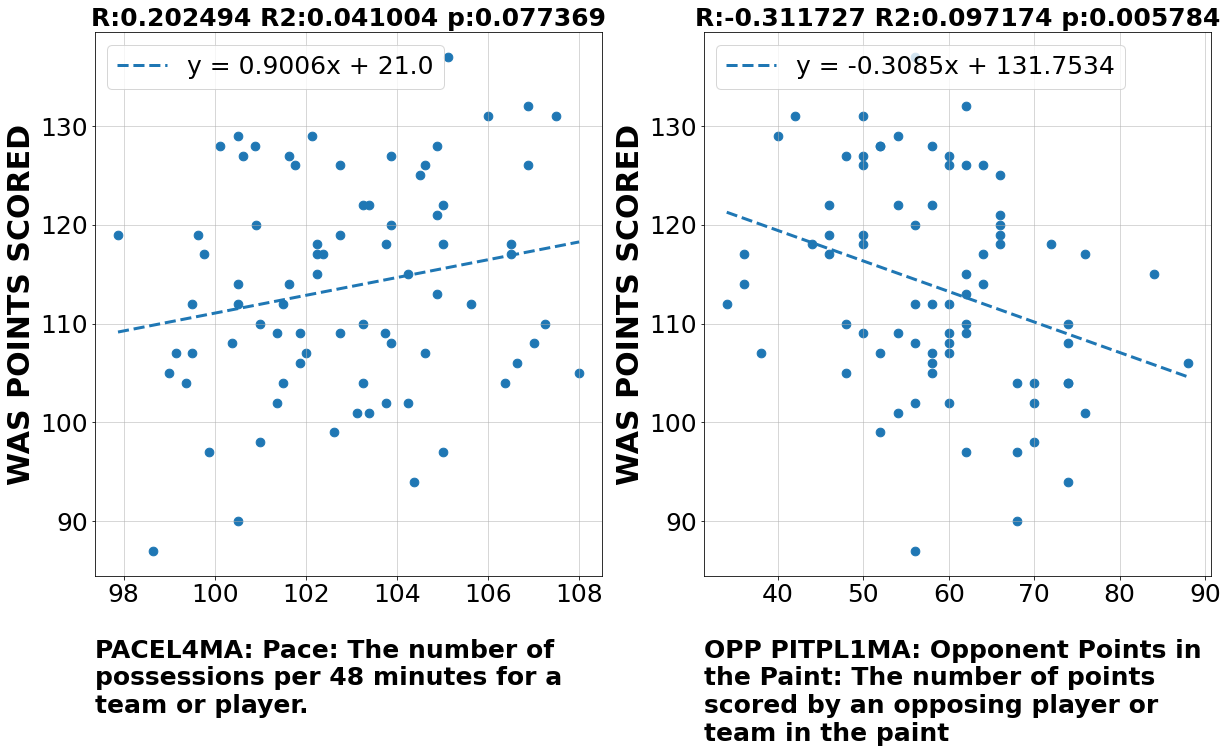

• For Washington Wizards games played in 2023-24 NBA Regular Season,
  Feature: Pace in last 4 games played (PACEL4MA) 
  has strongest correlation to points scored

• For Washington Wizards games played in 2023-24 NBA Regular Season,
  Feature: Opponent Points in the Paint in last game played feature(OPP PITPL1MA) 
  has weakest correlation to points scored


In [128]:
plotTeamMaxMinFeatureToPointsCorrelation('WAS',NBAdf,leagueCorrelationResultsDF)
printTeamResults('WAS')